# Problema de negócio

## Hotel Chain Cancellation Rating - Classificação de cancelamentos de reservas de hospedagem

Contexto de Negócio:
    
A Costa del Data é uma tradicional rede hoteleira espanhola. Ela possui hoje hotéis de 4 e 5 estrelas em todo o território nacional.

A empresa está preocupada com as suas projeções para os próximos anos, visando a recuperação financeira com o fim das restrições impostas pela pandemia de Covid-19.

Com a reabertura das fronteiras, a diminuição nas restrições de viagem e o aumento das vacinações, era esperado que o setor hoteleiro da Espanha retomasse os ganhos outrora esperados.

Na contramão desta expectativa, a Costa del Data tem visto um aumento em sua taxa de cancelamentos de reservas! A suspeita da diretoria é de que houve uma mudança no comportamento de cancelamentos por parte do consumidor após a pandemia, que ainda não foi compreendida pela rede.

Isso travou ações estratégicas críticas como a expansão da rede hoteleira, a reforma das unidades já com obras programadas, e a realização de ações de marketing direcionadas.

O seu time de cientistas de dados foi contratado, para compreender o fenômeno dos cancelamentos de reservas. Em posse dos resultados, o time de marketing tomará decisões mais assertivas, focando nos públicos com menor incidência de cancelamento, revertendo assim o cenário negativo atual.

Com base no histórico de reservas dos hóspedes, seu time deve desenvolver um modelo de previsão de cancelamentos. O modelo deve prever a variável alvo "Reserva Cancelada", retornando 1 em caso de cancelamento, e 0 em caso de não cancelamento.

Para esta competição, desconsiderem fatores recentes como: conflitos armados, aumento de preços energéticos, acordos comerciais e aprovações orçamentárias que envolvam a Espanha, Europa ou mesmo o mundo.

Métrica de Avaliação do problema: F-Score (Macro).

## Passos para a resolução do problema

Para resolver o problema será utilizado o método CRISP DS. O CRISP DS é um método adaptado para a Ciência de Dados, onde são realizadas diversas etapas sequenciais as quais não devem ser interrompidas. Ao finalizar a última etapa, o ciclo reinicia e novas alterações são adicionadas a resolução do problema. Desta forma, é possível entregar uma solução completa com eficiência e rapidez, a qual pode ser aperfeiçoada diversas vezes em ciclos posteriores.

Neste projeto foi realizado um ciclo completo do CRISP DS, contemplando as seguintes etapas:
1. Levantamento do problema de negócio:
- Contexto do problema;
- Passos para a resolução do problema;
- Planejamento da solução.
2. Carregamento dos dados:
- Visão geral dos dados;
- Descrição dos atributos.
3. Limpeza dos dados:
- Aplicação de premissas;
- Descrição dos dados;
- Tratativa de outliers.
4. Análise exploratória de dados:
- Formulação de hipóteses de negócio;
- Proporção de cancelamento de variáveis;
- Análise de variáveis categóricas;
- Análise de variáveis numéricas;
- Conclusão e geração de insights.
5. Preparação dos dados:
- Encodings;
- Seleção de features por importância.
6. Implementação dos modelos de Machine Learning:
- Teste de modelos iniciais;
- Tunagem de parâmetros do modelo escolhido;
- Teste de generalização do modelo escolhido.
7. Resultados financeiros:
- Tradução do erro do modelo;
- Exemplo prático do ganho financeiro do modelo.
8. Modelo em produção:
- Design do ETL;
- Armazenamento do modelo treinado na nuvem;
- Desenvolvimento de API para verificar as reservas canceladas de acordo com o id dos usuários;
- Desenvolvimento de Bot no Telegram para verificar as reservas canceladas de acordo com o id dos usuários.


## Planejamento da solução

Fonte dos dados: https://www.kaggle.com/competitions/cdshackdays4/data

Ferramentas utilizadas: Python 3.9.16 e bibliotecas (contidas no arquivo do projeto 'requirements.txt').

Formato da entrega:
1. Arquivo CSV 'submission.csv' com as previsões para cada id do conjunto de teste.
2. Bot no telegram com as previsões para cada id do conjunto de teste.

# Configurações iniciais

## Importações

In [1]:
import math
import statistics
import random
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import xgboost as xgb
import lightgbm as lgbm

from matplotlib            import gridspec
from matplotlib.pyplot     import figure

import scipy.stats         as ss
import matplotlib.pyplot   as plt

from category_encoders.count import CountEncoder
import category_encoders as ce

from dython import nominal
from itertools import combinations

from IPython.display         import Image
from IPython.core.display    import HTML

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder       
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

from sklearn                 import datasets               as dt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics         import f1_score, make_scorer
from sklearn                 import metrics as mt
from sklearn import linear_model

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import sweetviz as sv

C:\Users\micro\anaconda3\envs\ds_em_producao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funções auxiliares

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape # conta todas as linhas e colunas
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def cramer_v_confusion_matrix(confusion_matrix):
    
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    chi2corr = max(0, chi2 - ((k-1)*(r-1))/(n-1))
    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt((chi2corr/n)/min((kcorr-1),(rcorr-1)))

def descriptive_statistics(df):
    # atributos numéricos
    num_attributes = df.select_dtypes(include=['int64', 'float64'])

    # atributos categóricos
    cat_attributes = df.select_dtypes(exclude=['int64', 'float64'])

    # tendência central - mean, meadina 
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
    d2 = pd.DataFrame(num_attributes.apply(min)).T 
    d3 = pd.DataFrame(num_attributes.apply(max)).T 
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

    # concatenar
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return m

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:75% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

# Carregamento dos dados

In [3]:
train = pd.read_csv('train.csv')

df = train.copy()

print('Os nomes das colunas são: \n{}\n'.format(df.columns))
print('As colunas e os tipos do conjunto de dados são: \n{}\n'.format(df.dtypes))
print('O tamanho do conjunto de dados é (linhas, colunas): \n{}\n'.format(df.shape))
print('A quantidade de linhas vazias para cada coluna é: \n{}\n'.format(df.isna().sum()))
print('A quantidade de usuários únicos do conjunto de dados é: \n{}'.format(df['id'].nunique()))

df.head(50) # amostra dos dados após o carregamento para uma visão geral do conjunto

Os nomes das colunas são: 
Index(['id', 'Classificação do hotel', 'Meses da reserva até o check-in',
       'Número de pernoites reservadas', 'Número de hospedes',
       'Regime de alimentação', 'Nacionalidade', 'Forma de Reserva',
       'Já se hospedou anterioremente', 'Tipo do quarto reservado',
       'Reserva feita por agência de turismo', 'Reserva feita por empresa',
       'Reserva com Estacionamento', 'Reserva com Observações',
       'Reserva Cancelada'],
      dtype='object')

As colunas e os tipos do conjunto de dados são: 
id                                        int64
Classificação do hotel                   object
Meses da reserva até o check-in           int64
Número de pernoites reservadas            int64
Número de hospedes                      float64
Regime de alimentação                    object
Nacionalidade                            object
Forma de Reserva                         object
Já se hospedou anterioremente            object
Tipo do quarto reservado  

,id,Classificação do hotel,Meses da reserva até o check-in,Número de pernoites reservadas,Número de hospedes,Regime de alimentação,Nacionalidade,Forma de Reserva,Já se hospedou anterioremente,Tipo do quarto reservado,Reserva feita por agência de turismo,Reserva feita por empresa,Reserva com Estacionamento,Reserva com Observações,Reserva Cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
5,101651,4 estrelas,6,4,3.0,Café da manha,Germany,Agência,Não,Green Emerald,Sim,Não,Não,1 a 3,0
6,24231,5 estrelas,1,906,2.0,Café da manha,United Kingdom,Balcão,Não,Amethyst,Não,Sim,Sim,1 a 3,0
7,85783,4 estrelas,2,2,1.0,Café da manha,Spain,B2B,Não,Pink Sapphire,Não,Sim,Não,1 a 3,0
8,88064,4 estrelas,1,1,2.0,Sem refeicao,Netherlands,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,0
9,82007,4 estrelas,1,3,2.0,Café da manha,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0


# Limpeza dos dados

## Premissas iniciais

- Para as linhas não preenchidas da coluna 'Número de hospedes' foi atribuida a quantidade mínima de hóspedes, que é de 1 hóspede.
- Para as linhas não preenchidas da coluna 'Nacionalidade' foi atribuído o país sede da rede hoteleira e que também se repete mais vezes, que é a Espanha.

In [4]:
# Renomeando colunas
df.columns = [i.replace(' ', '_') for i in df.columns]
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, df.columns))
cols_new = ['id',
 'classificacao_do_hotel',
 'meses_da_reserva_ate_o_check_in',
 'numero_de_pernoites_reservadas',
 'numero_de_hospedes',
 'regime_de_alimentacao',
 'nacionalidade',
 'forma_de_reserva',
 'ja_se_hospedou_anteriormente',
 'tipo_do_quarto_reservado',
 'reserva_feita_por_agencia_de_turismo',
 'reserva_feita_por_empresa',
 'reserva_com_estacionamento',
 'reserva_com_observacoes',
 'reserva_cancelada']
df.columns = cols_new
df.columns

Index(['id', 'classificacao_do_hotel', 'meses_da_reserva_ate_o_check_in',
       'numero_de_pernoites_reservadas', 'numero_de_hospedes',
       'regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva',
       'ja_se_hospedou_anteriormente', 'tipo_do_quarto_reservado',
       'reserva_feita_por_agencia_de_turismo', 'reserva_feita_por_empresa',
       'reserva_com_estacionamento', 'reserva_com_observacoes',
       'reserva_cancelada'],
      dtype='object')

In [5]:
# limpando coluna classificação do hotel
df['classificacao_do_hotel'] = df.apply(lambda line: line['classificacao_do_hotel'].replace(' estrelas', ' '), axis = 1)

# preenchendo NAS da coluna número de hospedes com o valor mínimo de hospedes
df['numero_de_hospedes'] = df['numero_de_hospedes'].apply(lambda x: 1 if math.isnan(x) else x)

# transformando tipos das colunas
df['classificacao_do_hotel'] = df['classificacao_do_hotel'].astype('int64')
df['numero_de_hospedes'] = df['numero_de_hospedes'].astype('int64')
df['numero_de_pernoites_reservadas'] = df['numero_de_pernoites_reservadas'].astype('int64')
df['meses_da_reserva_ate_o_check_in'] = df['meses_da_reserva_ate_o_check_in'].astype('int64')

# criando coluna resposta categórica para posterior análise exploratória
df['reserva_cancelada_cat'] = df.apply(lambda x: 'Sim' if x['reserva_cancelada'] == 1 else 'Não', axis = 1)

# transformando as colunas categóricas de não em sim em numéricas de 0 e 1 para facilitar as análises
df['ja_se_hospedou_anteriormente'] = df['ja_se_hospedou_anteriormente'].apply(lambda x: 0 if x == 'Não' else 1)
df['reserva_com_estacionamento'] = df['reserva_com_estacionamento'].apply(lambda x: 0 if x == 'Não' else 1)
df['reserva_feita_por_agencia_de_turismo'] = df['reserva_feita_por_agencia_de_turismo'].apply(lambda x: 0 if x == 'Não' else 1)
df['reserva_feita_por_empresa'] = df['reserva_feita_por_empresa'].apply(lambda x: 0 if x == 'Não' else 1)

# preenchendo os NAs da nacionalidade com Espanha, por ser o país da rede hoteleira
df = df.fillna('spain')
# df = df.fillna('nan') # opção para substituir NaNs posteriormente utilizando algum algoritmo de classificação

In [6]:
# Renomeando linhas das colunas categóricas

# nacionalidade
rows_nac = list(map(snakecase, df['nacionalidade']))
df['nacionalidade'] = rows_nac
df['nacionalidade'] = [i.replace(' ', '_') for i in df['nacionalidade']]
df['nacionalidade'] = [i.replace(',', '_') for i in df['nacionalidade']]
df['nacionalidade'] = [i.replace("'", '_') for i in df['nacionalidade']]
df['nacionalidade'] = [i.replace("ô", 'o') for i in df['nacionalidade']]
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'russia' if (x == 'russia') | (x == 'russian_federation') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'south_korea' if (x == 'south_korea') | (x == 'korea__republic_of') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'ivory_coast' if (x == 'ivory_coast') | (x == 'cote_d_ivoire') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'iran' if (x == 'iran') | (x == 'iran__islamic_republic_of') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'tanzania' if (x == 'tanzania') | (x == 'tanzania__united_republic_of') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'taiwan' if (x == 'taiwan') | (x == 'taiwan__province_of_china') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'france' if (x == 'france') | (x == 'monaco') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'venezuela' if (x == 'venezuela') | (x == 'venezuela__bolivarian_republic_of') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'bolivia' if (x == 'bolivia') | (x == 'bolivia__plurinational_state_of') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'macedonia' if (x == 'macedonia') | (x == 'macedonia__the_former_yugoslav_republic_of') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'dominican_republic' if (x == 'dominica') | (x == 'dominican_republic') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'libya' if (x == 'libya') | (x == 'libyan_arab_jamahiriya') else x)
df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'vietnam' if (x == 'vietnam') | (x == 'viet_nam') else x)
# df['nacionalidade'].unique()

# tipo do quarto reservado
rows_quarto = list(map(snakecase, df['tipo_do_quarto_reservado']))
df['tipo_do_quarto_reservado'] = rows_quarto
df['tipo_do_quarto_reservado'] = [j.replace(' ', '_') for j in df['tipo_do_quarto_reservado']]

# regime de alimentação
df['regime_de_alimentacao'] = df['regime_de_alimentacao'].apply(lambda x: 'cafe_almoco_janta' if (x == 'Café da manha, almoco e jantar') else
                                                                          'cafe_janta' if (x == 'Café da manha e jantar') else
                                                                          'cafe' if (x == 'Café da manha') else
                                                                          'sem_refeicao' if (x == 'Sem refeicao') else x)

# reserva com observações
df['reserva_com_observacoes'] = df['reserva_com_observacoes'].apply(lambda x: 'nenhuma' if (x == 'Nenhuma') else
                                                                              '1_a_3' if (x == '1 a 3') else
                                                                              'mais_de_3' if (x == 'Mais de 3') else x)

# forma de reserva
df['forma_de_reserva'] = df['forma_de_reserva'].apply(lambda x: 'agencia' if (x == 'Agência') else 
                                                      'balcao' if (x == 'Balcão') else 
                                                      'b2b' if (x == 'B2B') else x)

## Descrição dos dados

In [7]:
# Descrição das variáveis numéricas
descriptive_statistics(df)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,120265.0,120264.0,60093.687787,60080.0,34725.787383,0.000051,-1.203219
1,classificacao_do_hotel,4.0,5.0,1.0,4.336133,4.0,0.472385,0.693802,-1.518681
2,meses_da_reserva_ate_o_check_in,1.0,311.0,310.0,7.145928,3.0,25.852151,8.667253,79.725538
3,numero_de_pernoites_reservadas,0.0,1172.0,1172.0,15.824152,3.0,98.247798,8.765012,80.204284
4,numero_de_hospedes,0.0,1153.0,1153.0,14.258221,2.0,96.443532,8.723448,79.668046
5,ja_se_hospedou_anteriormente,0.0,1.0,1.0,0.031292,0.0,0.174106,5.384287,26.991298
6,reserva_feita_por_agencia_de_turismo,0.0,1.0,1.0,0.863205,1.0,0.343631,-2.113968,2.468929
7,reserva_feita_por_empresa,0.0,1.0,1.0,0.056736,0.0,0.231337,3.832272,12.686660
8,reserva_com_estacionamento,0.0,1.0,1.0,0.061711,0.0,0.240630,3.642925,11.271215
9,reserva_cancelada,0.0,1.0,1.0,0.370418,0.0,0.482917,0.536675,-1.712028


## Trativa de outliers

- Foram tratadas como outliers as linhas da coluna 'Meses da reserva até o check-in' acima de 24 meses, as linhas da coluna 'Número de pernoites reservadas' acima de 30 pernoites e as linhas da coluna 'Número de hospedes' acima de 6 hóspedes, pois foi verificado que a quantidade de reservas totais para estas condições decaia drásticamente, acrescentando quantidades irrelevantes à análise e indicando possíveis preenchimentos equivocados.
- Foram eliminadas as linhas da coluna 'Número de pernoites reservadas' igual a 0 e as linhas da coluna 'Número de hospedes' igual a 0, pois subentende-se que deve ser reservada pelo menos uma pernoite e deve haver pelo menos 1 hóspede.

In [8]:
print(df[['meses_da_reserva_ate_o_check_in']].value_counts().reset_index().sort_values(by = 'meses_da_reserva_ate_o_check_in'))
print(df[['numero_de_pernoites_reservadas']].value_counts().reset_index().sort_values(by = 'numero_de_pernoites_reservadas'))
print(df[['numero_de_hospedes']].value_counts().reset_index().sort_values(by = 'numero_de_hospedes'))

df = df[df['meses_da_reserva_ate_o_check_in'] <= 24]
df = df[(df['numero_de_pernoites_reservadas'] != 0) & (df['numero_de_pernoites_reservadas'] <= 30)]
df = df[(df['numero_de_hospedes'] != 0) & (df['numero_de_hospedes'] <= 6)]

     meses_da_reserva_ate_o_check_in      0
0                                  1  22858
1                                  2  10336
2                                  3   7680
3                                  4   6046
4                                  5   5052
5                                  6   4686
6                                  7   3375
7                                  8   2433
8                                  9   2148
9                                 10   1962
10                                11   1506
11                                12    893
12                                13    566
13                                14    404
14                                15    315
15                                16    240
16                                17     72
17                                18     66
20                                19     36
18                                20     53
19                                21     53
22                              

# Análise exploratória dos dados

Motivação para realização da análise exploratória dos dados (EDA):
- 1. Confirmar ou não as hipóteses estabelecidas previamente.
- 2. Chocar outras crenças prévias do time de negócio da empresa.
- 3. Encontrar padrões no comportamento dos dados.
- 4. Descobrir as características mais relevantes para posterior modelagem dos dados sem depender apenas de uma análise de Machine Learning.
- 5. Encontrar valores que destoam do padrão dos demais valores, pois estes possuem grandes chances de virar insights para o time de negócio da empresa.

## Formulação das hipóteses

Premissa: apesar de numéricas, as colunas 'Já se hospedou anterioremente', 'Reserva com Estacionamento', 'Classificação do hotel', 'Reserva feita por empresa' e 'Reserva feita por agência de turismo' indicam classificações. Neste caso, serão interpretadas como categóricas.

Hipóteses relacionadas as variáveis categóricas:
- 1. Hotéis com classificação 5 estrelas possuem uma proporção de cancelamentos menor que hotéis com classificação de 4 estrelas.
- 2. Clientes que já se hospedaram anteriormente possuem uma proporção de cancelamentos menor que clientes que nunca se hospedaram antes.
- 3. Reservas feitas por balcão tem uma proporção de cancelamento maior que as realizadas por agência de turismo ou B2B.
- 4. Reservas feitas com estacionamento possuem uma menor proporção de cancelamento.
- 5. Reservas feitas com café da manhã, almoço e jantar possuem uma menor proporção de cancelamento que as demais.
- 6. Reservas feitas sem nenhuma observação possuem uma maior proporção de cancelamento que as demais.
- 7. Reservas feitas por países do continente europeu possuem uma menor proporção de cancelamento as demais.

Hipóteses relacionadas as variáveis numéricas:
- 8. Reservas feitas com um tempo igual ou menor a 2 meses do período de check-in possuem uma menor proporção de cancelamento.
- 9. Reservas feitas com apenas uma pernoite possuem uma maior quantidade de cancelamentos em média que as demais.
- 10. Reservas feitas com 2 hóspedes possuem uma maior quantidade de cancelamentos em média que as demais.

## Proporções de cancelamento de cada coluna

In [9]:
list_prop = ['classificacao_do_hotel',
 'meses_da_reserva_ate_o_check_in',
 'numero_de_pernoites_reservadas',
 'numero_de_hospedes',
 'regime_de_alimentacao',
 'nacionalidade',
 'forma_de_reserva',
 'ja_se_hospedou_anteriormente',
 'tipo_do_quarto_reservado',
 'reserva_feita_por_agencia_de_turismo',
 'reserva_feita_por_empresa',
 'reserva_com_estacionamento',
 'reserva_com_observacoes']

for i in list_prop:
    prop_canc = pd.crosstab(df[i], df['reserva_cancelada'], normalize = 'index')
    # o parâmetro 'normalize' que normaliza as colunas proporcionalmente de acordo com a contagens de linhas = 0 e de linhas = 1
    print(f'A coluna {i} tem a seguinte proporção de cancelamento: \n{prop_canc}\n')

A coluna classificacao_do_hotel tem a seguinte proporção de cancelamento: 
reserva_cancelada              0         1
classificacao_do_hotel                    
4                       0.581417  0.418583
5                       0.717526  0.282474

A coluna meses_da_reserva_ate_o_check_in tem a seguinte proporção de cancelamento: 
reserva_cancelada                       0         1
meses_da_reserva_ate_o_check_in                    
1                                0.812549  0.187451
2                                0.631648  0.368352
3                                0.595748  0.404252
4                                0.562921  0.437079
5                                0.557255  0.442745
6                                0.531665  0.468335
7                                0.539555  0.460445
8                                0.514592  0.485408
9                                0.452135  0.547865
10                               0.310473  0.689527
11                               0.352657  0

## Análise das variáveis numéricas

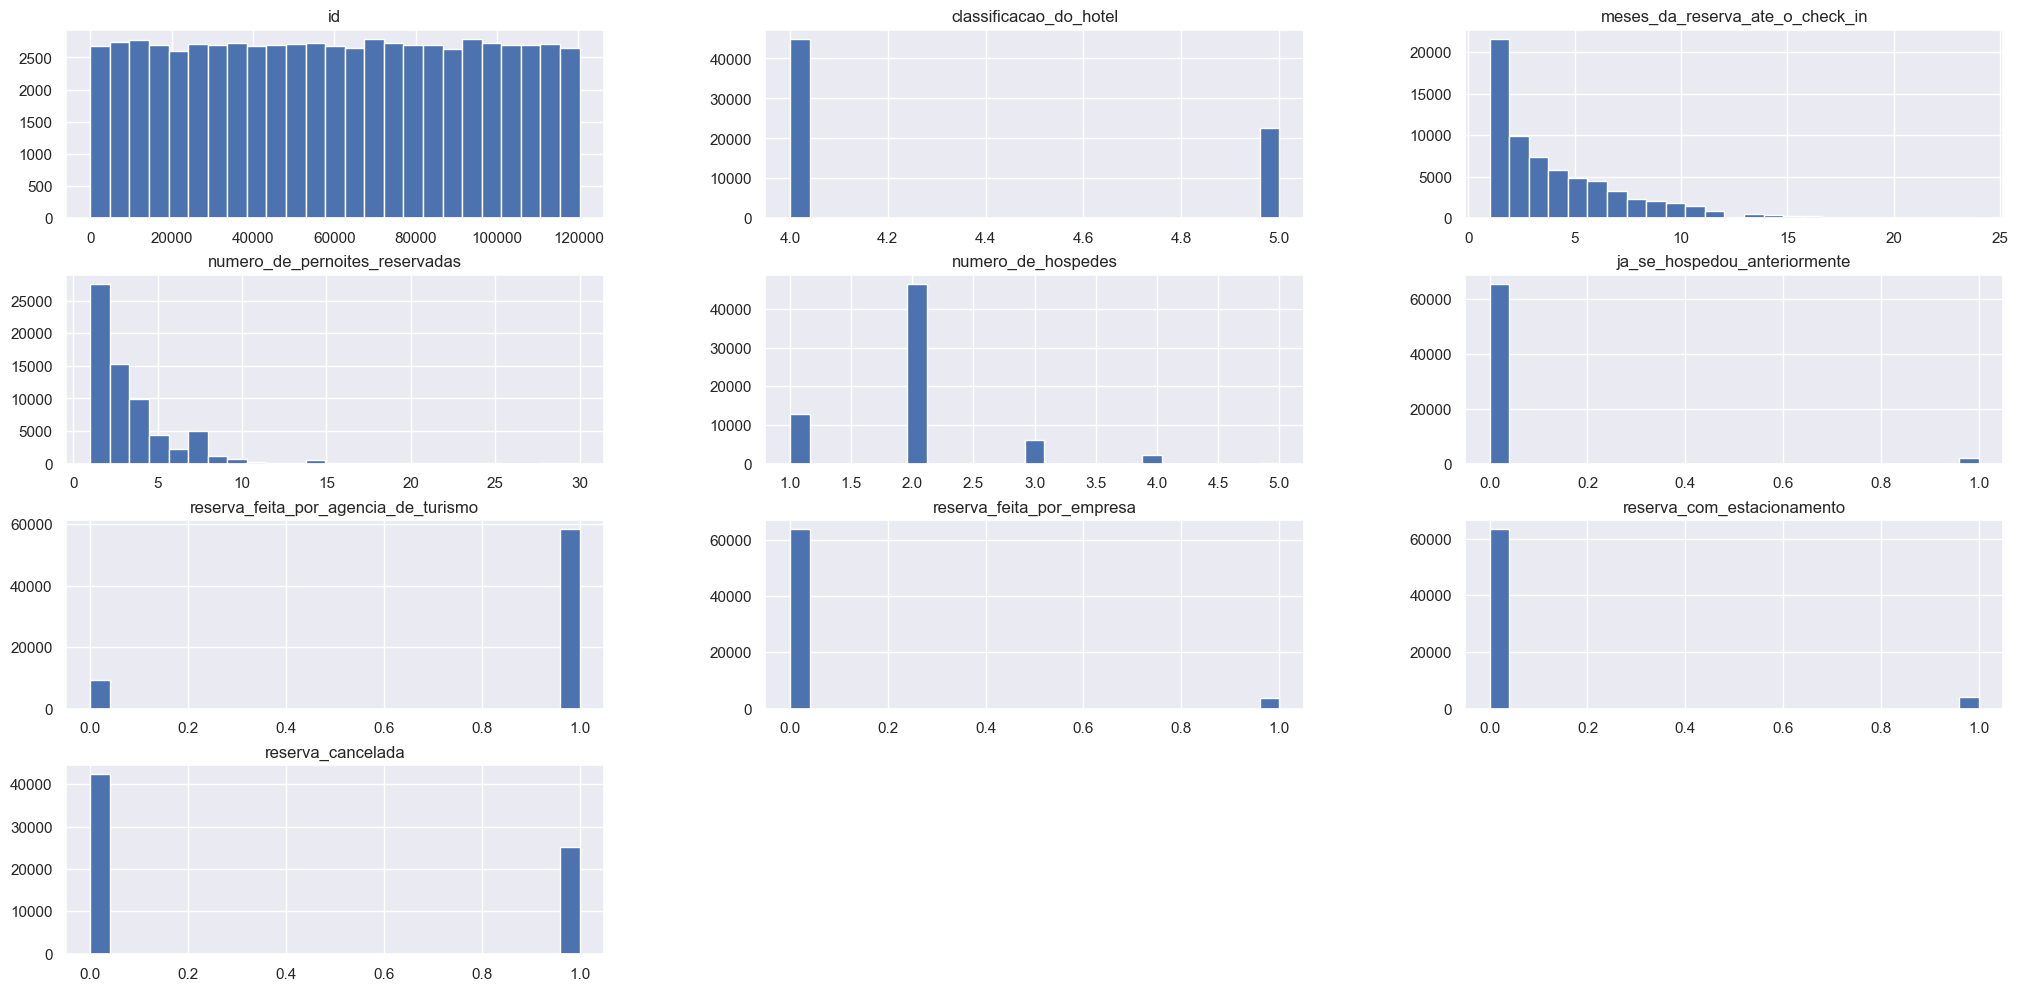

In [10]:
# análise univariada:
num_attributes = df.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins = 25);

In [11]:
# análise univariada da variável resposta:
df['reserva_cancelada'].value_counts(normalize = True).reset_index()

,index,reserva_cancelada
0,0,0.627005
1,1,0.372995


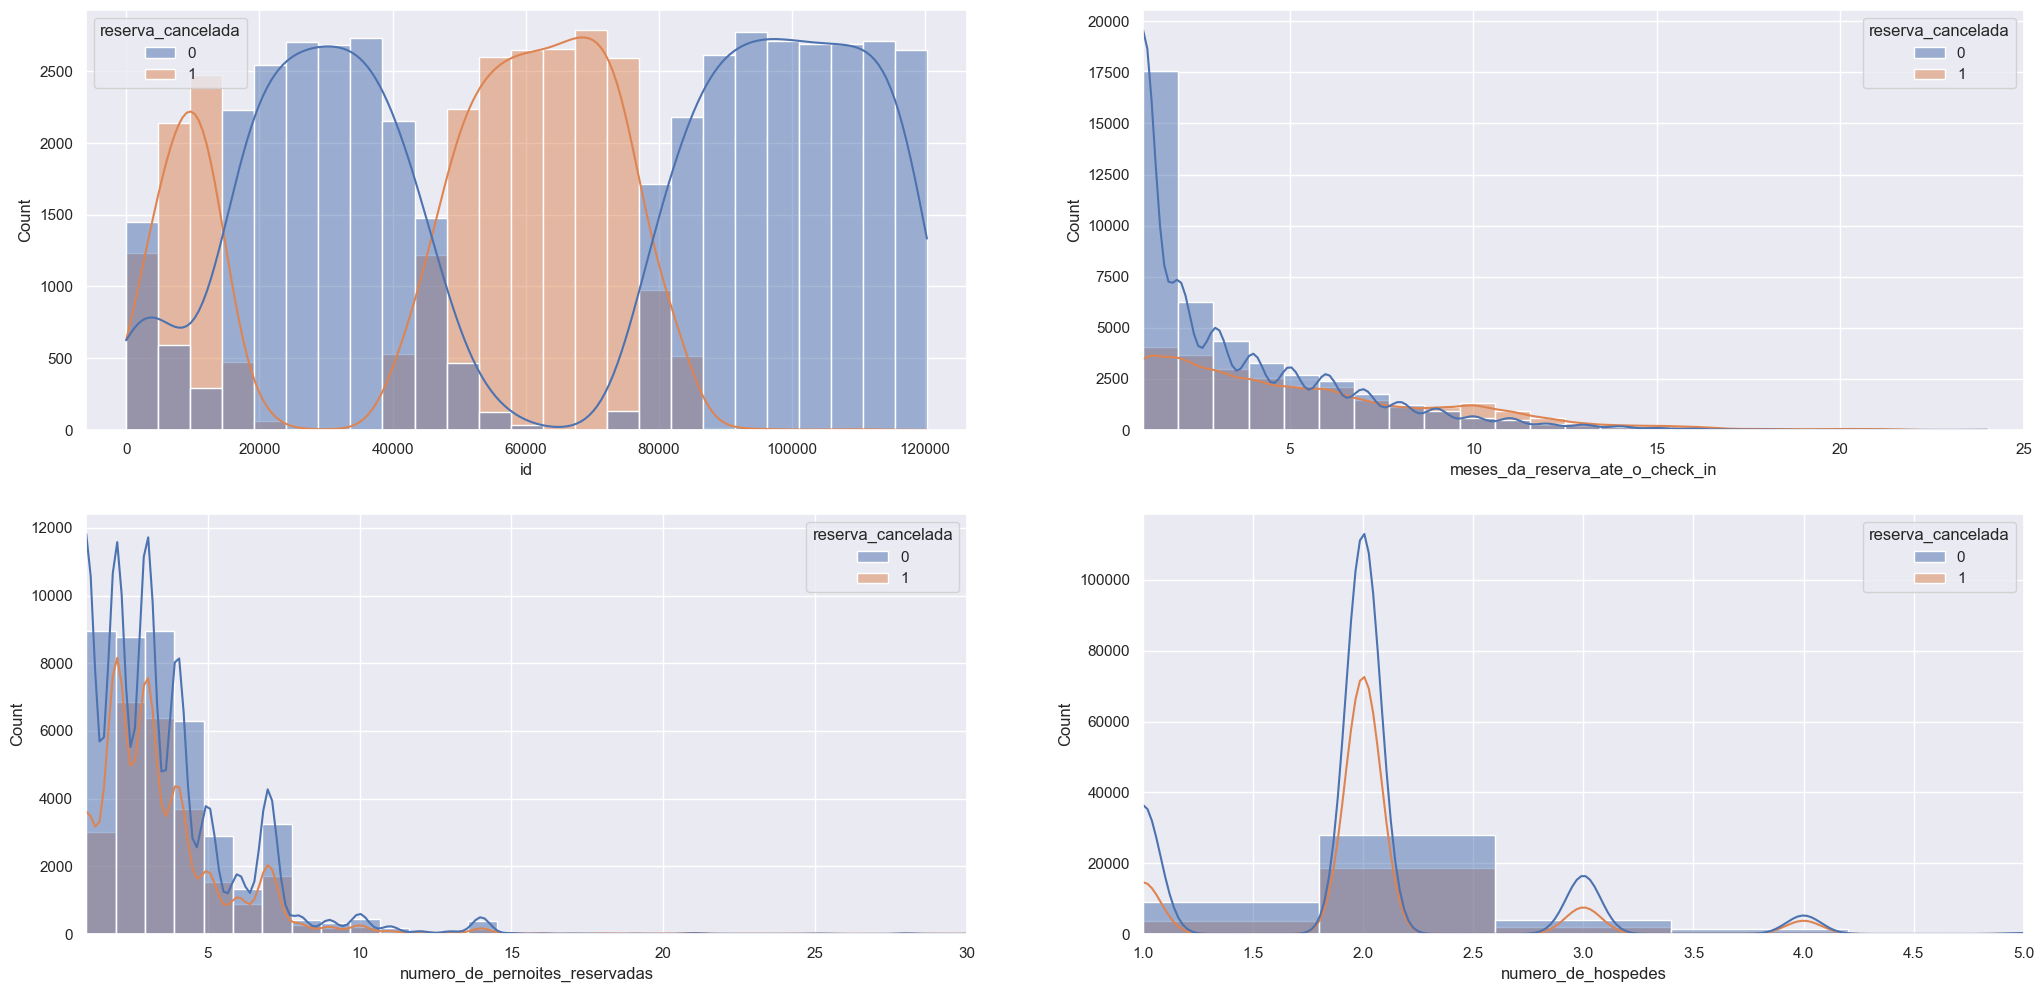

In [12]:
# análise bivariada:

plt.subplot(2, 2, 1)
sns.histplot(data = df, x = 'id', kde = True, bins = 25, hue = 'reserva_cancelada')

plt.subplot(2, 2, 2)
sns.histplot(data = df, x = 'meses_da_reserva_ate_o_check_in', kde = True, bins = 24, hue = 'reserva_cancelada')
plt.xlim([1, 25]);

plt.subplot(2, 2, 3)
sns.histplot(data = df, x = 'numero_de_pernoites_reservadas', kde = True, bins = 30, hue = 'reserva_cancelada')
plt.xlim([1, 30]);

plt.subplot(2, 2, 4)
sns.histplot(data = df, x = 'numero_de_hospedes', kde = True, bins = 5, hue = 'reserva_cancelada')
plt.xlim([1, 5]);

## Análise das variáveis categóricas

<AxesSubplot: xlabel='reserva_cancelada', ylabel='count'>

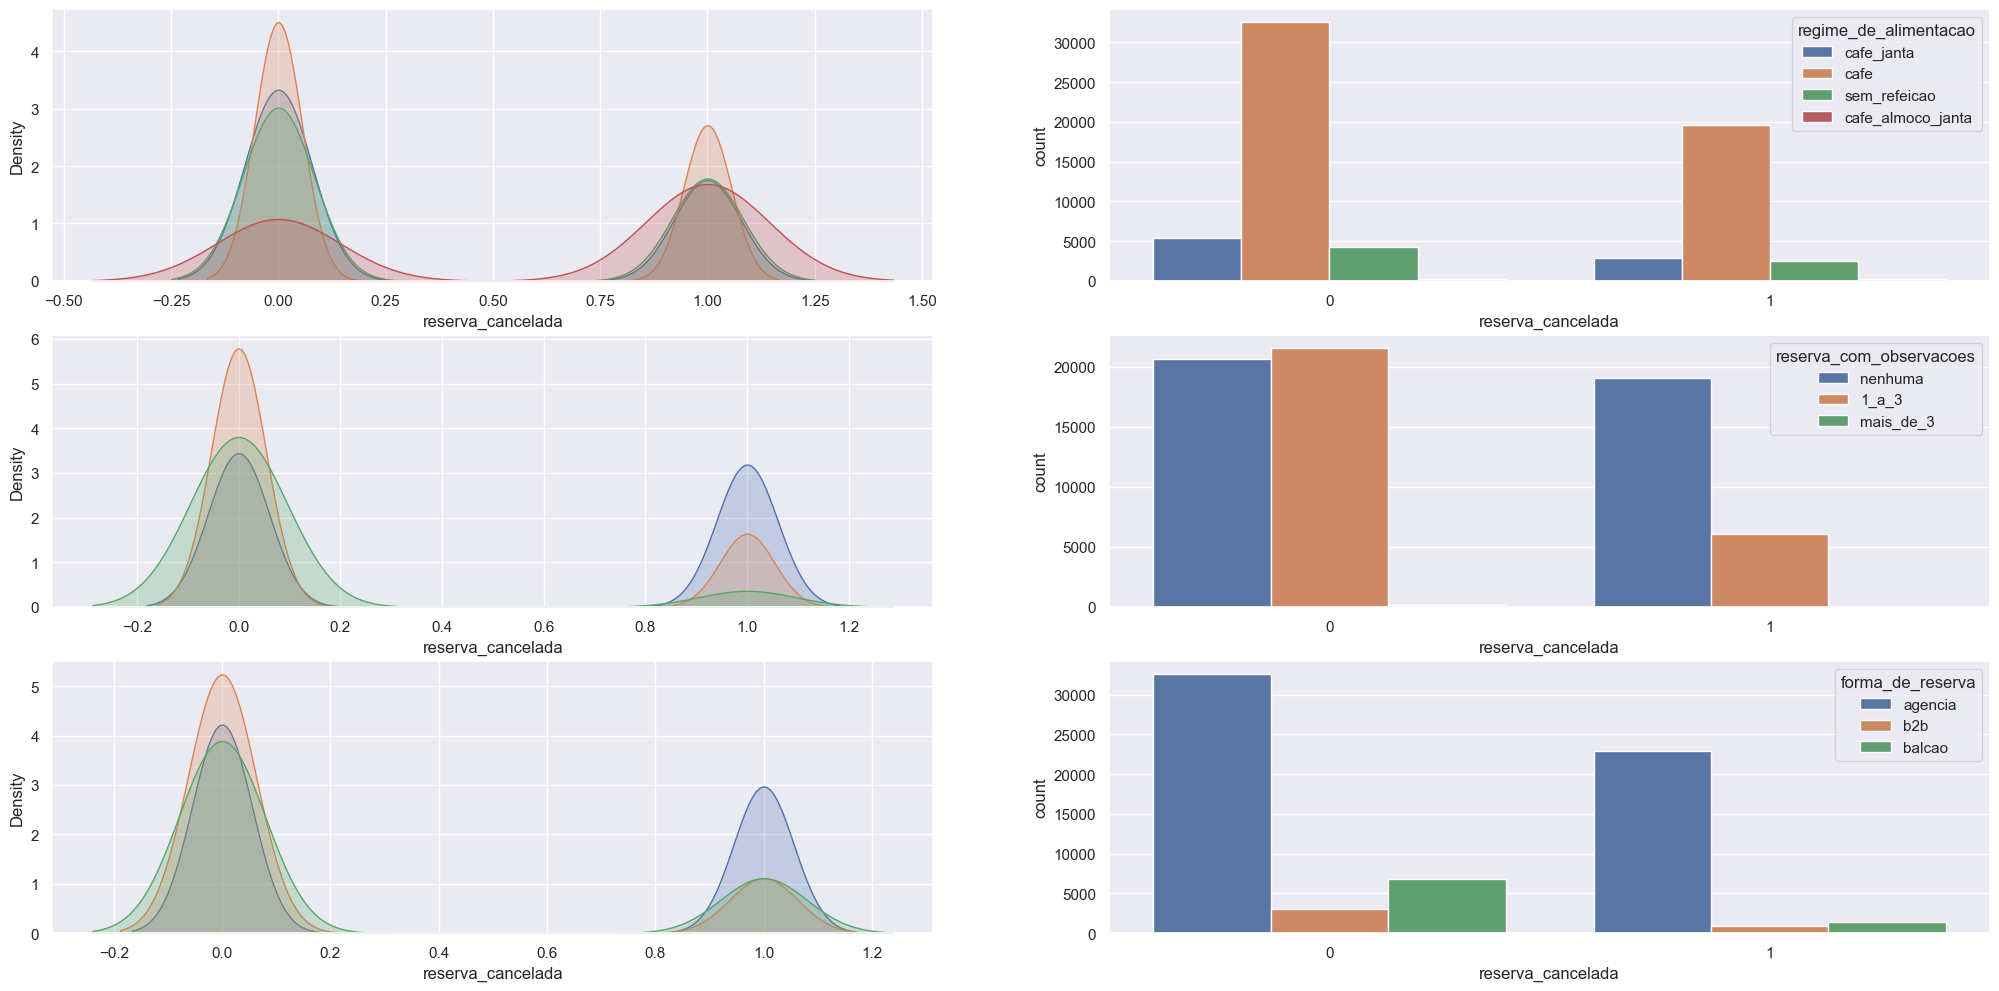

In [13]:
# Regime de alimentação
plt.subplot(3, 2, 1)
sns.kdeplot(df[df['regime_de_alimentacao'] == 'cafe_janta']['reserva_cancelada'], label='cafe_janta', fill=True)
sns.kdeplot(df[df['regime_de_alimentacao'] == 'cafe']['reserva_cancelada'], label='cafe', fill=True)
sns.kdeplot(df[df['regime_de_alimentacao'] == 'sem_refeicao']['reserva_cancelada'], label='sem_refeicao', fill=True)
sns.kdeplot(df[df['regime_de_alimentacao'] == 'cafe_almoco_janta']['reserva_cancelada'], label='cafe_almoco_janta', fill=True)

# Regime de alimentação
plt.subplot(3, 2, 2)
sns.countplot(x = df['reserva_cancelada'], hue = df['regime_de_alimentacao'])

# Reserva com Observações
plt.subplot(3, 2, 3)
sns.kdeplot(df[df['reserva_com_observacoes'] == 'nenhuma']['reserva_cancelada'], label='nenhuma', fill=True)
sns.kdeplot(df[df['reserva_com_observacoes'] == '1_a_3']['reserva_cancelada'], label='1_a_3', fill=True)
sns.kdeplot(df[df['reserva_com_observacoes'] == 'mais_de_3']['reserva_cancelada'], label='mais_de_3', fill=True)

# Reserva com Observações
plt.subplot(3, 2, 4)
sns.countplot(x = df['reserva_cancelada'], hue = df['reserva_com_observacoes'])

# Forma de Reserva
plt.subplot(3, 2, 5)
sns.kdeplot(df[df['forma_de_reserva'] == 'agencia']['reserva_cancelada'], label='agencia', fill=True)
sns.kdeplot(df[df['forma_de_reserva'] == 'balcao']['reserva_cancelada'], label='balcao', fill=True)
sns.kdeplot(df[df['forma_de_reserva'] == 'b2b']['reserva_cancelada'], label='b2b', fill=True)

# Forma de Reserva
plt.subplot(3, 2, 6)
sns.countplot(x = df['reserva_cancelada'], hue = df['forma_de_reserva'])

<AxesSubplot: xlabel='reserva_cancelada', ylabel='count'>

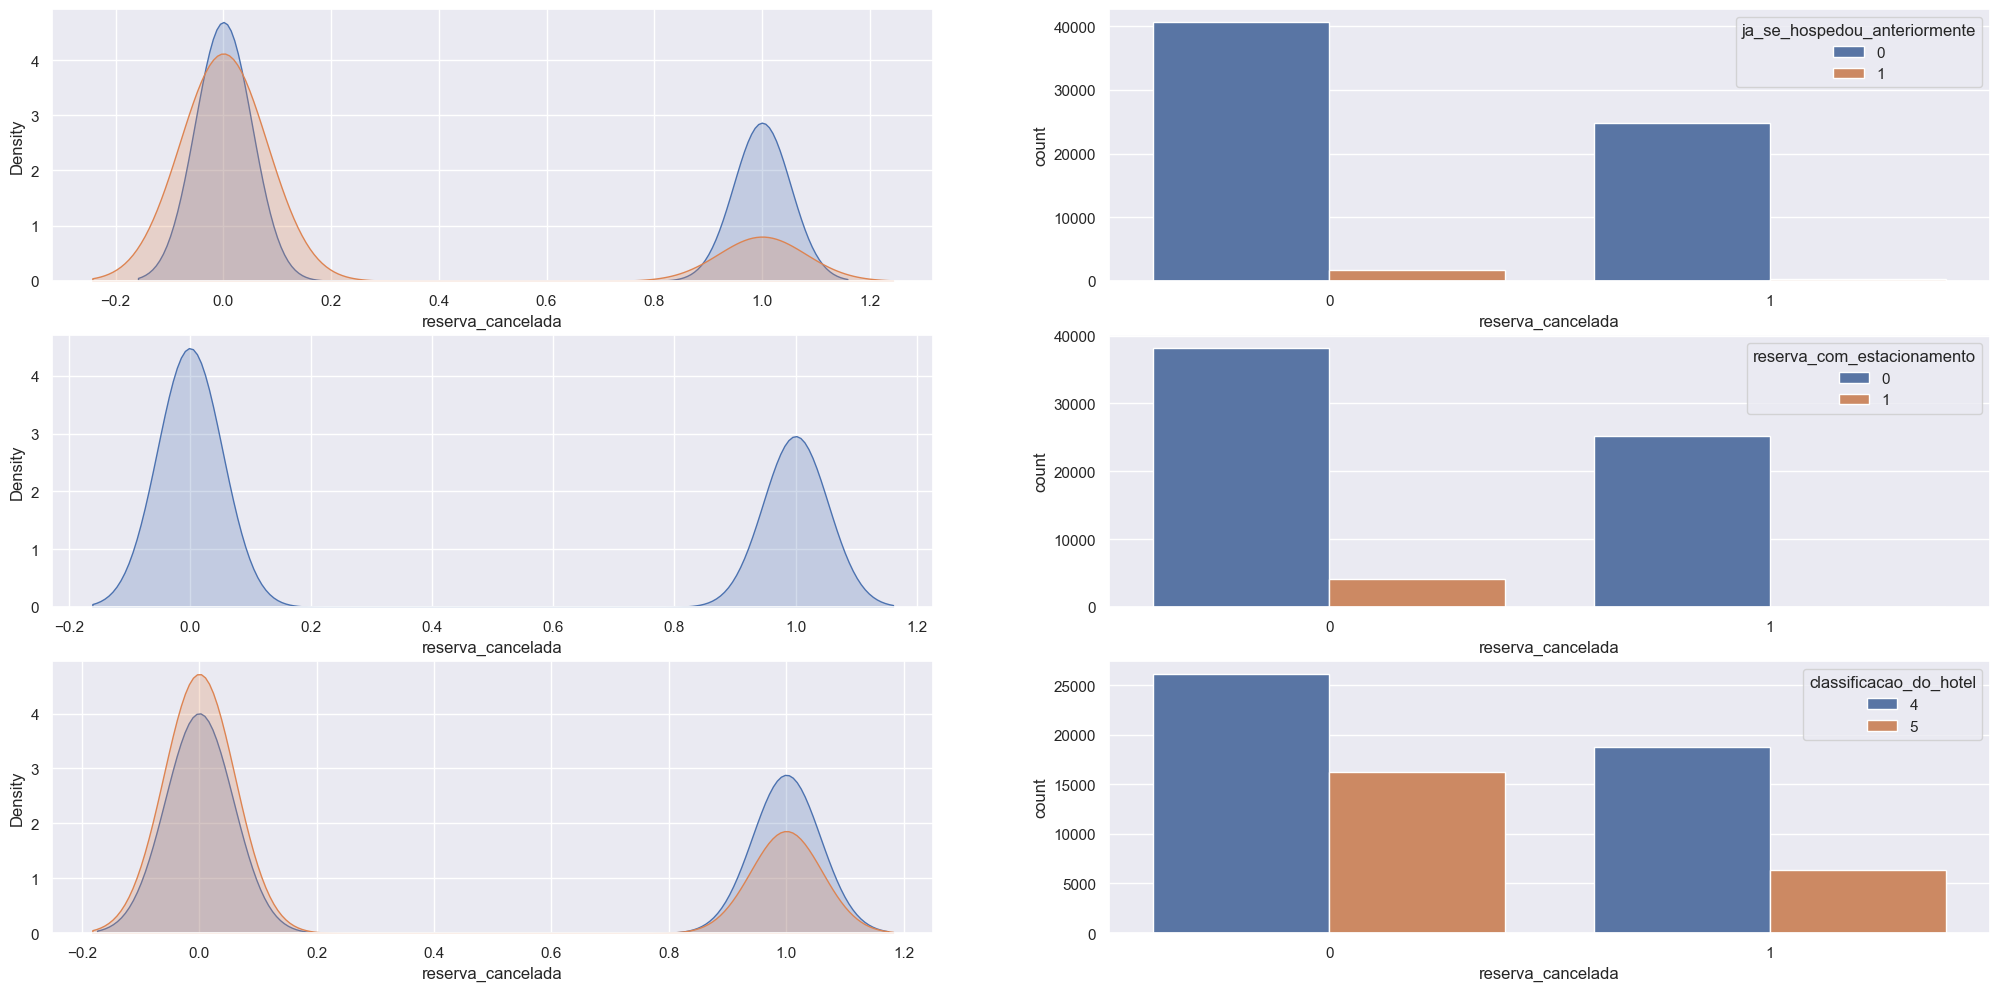

In [14]:
# Já se hospedou anterioremente
plt.subplot(3, 2, 1)
sns.kdeplot(df[df['ja_se_hospedou_anteriormente'] == 0]['reserva_cancelada'], label=0, fill=True)
sns.kdeplot(df[df['ja_se_hospedou_anteriormente'] == 1]['reserva_cancelada'], label=1, fill=True)

# Já se hospedou anterioremente
plt.subplot(3, 2, 2)
sns.countplot(x = df['reserva_cancelada'], hue = df['ja_se_hospedou_anteriormente'])

# Reserva com Estacionamento
plt.subplot(3, 2, 3)
sns.kdeplot(df[df['reserva_com_estacionamento'] == 0]['reserva_cancelada'], label=0, fill=True, warn_singular=False)
sns.kdeplot(df[df['reserva_com_estacionamento'] == 1]['reserva_cancelada'], label=1, fill=True, warn_singular=False)

# Reserva com Estacionamento
plt.subplot(3, 2, 4)
sns.countplot(x = df['reserva_cancelada'], hue = df['reserva_com_estacionamento'])

# Classificação do hotel
plt.subplot(3, 2, 5)
sns.kdeplot(df[df['classificacao_do_hotel'] == 4]['reserva_cancelada'], label=4, fill=True)
sns.kdeplot(df[df['classificacao_do_hotel'] == 5]['reserva_cancelada'], label=5, fill=True)

# Classificação do hotel
plt.subplot(3, 2, 6)
sns.countplot(x = df['reserva_cancelada'], hue = df['classificacao_do_hotel'])

<AxesSubplot: xlabel='nacionalidade', ylabel='Quantidade'>

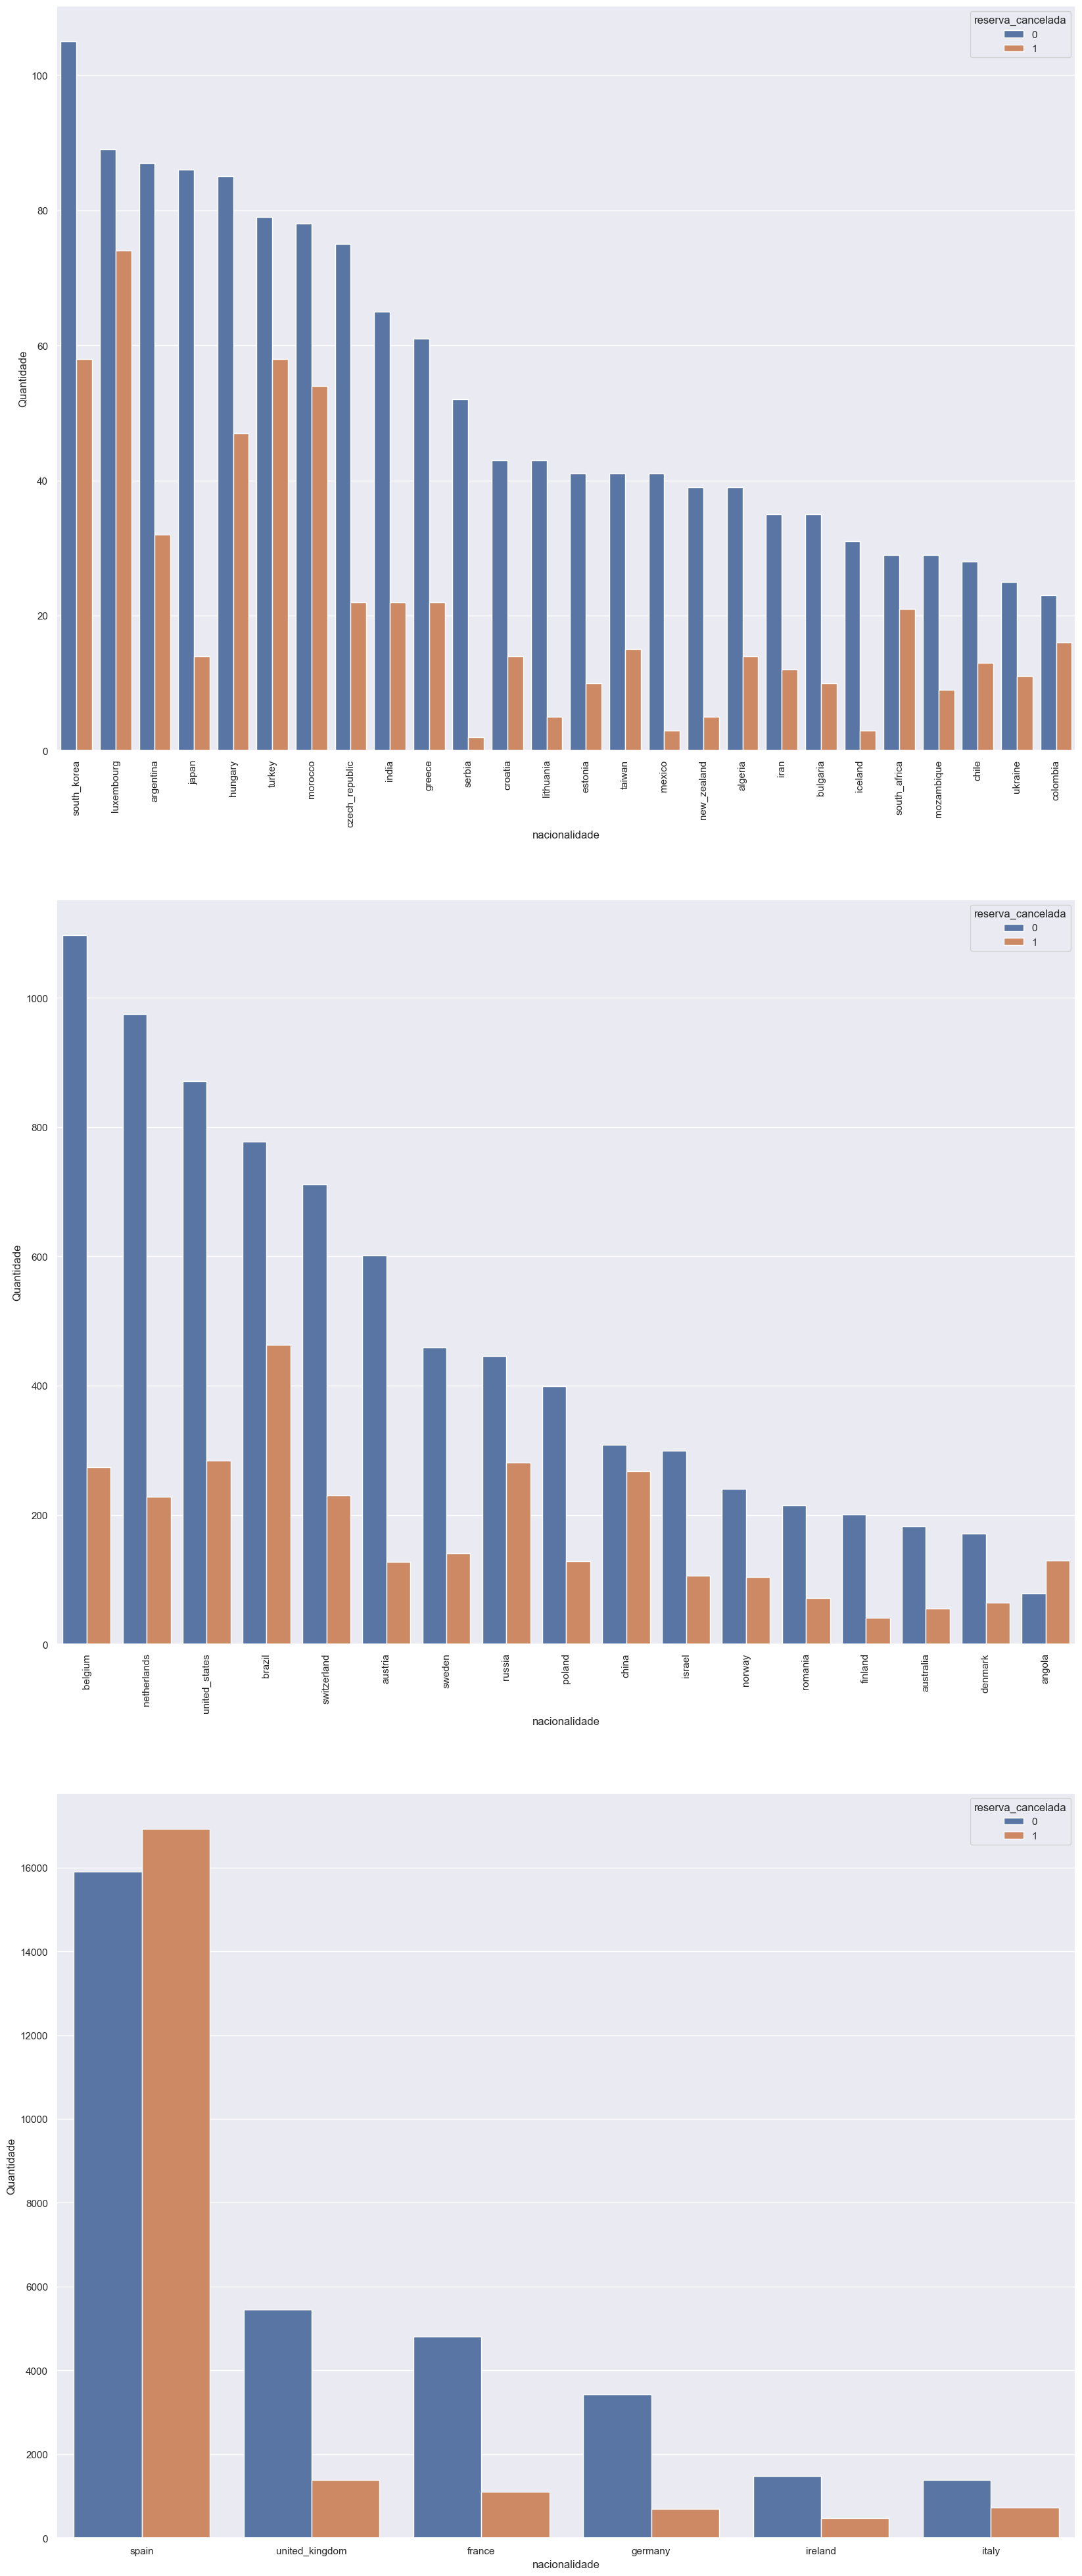

In [15]:
# Nacionalidade
# count_nac = df['nacionalidade'].value_counts().reset_index()
# count_nac['index'].unique()

nacionalidade = df[['nacionalidade', 'reserva_cancelada']].value_counts().reset_index()
nacionalidade = nacionalidade.rename(columns={0: 'Quantidade'}).sort_values(by = 'Quantidade', ascending = False)

nacionalidade_muito_grande = ['spain', 'united_kingdom', 'france', 'germany', 'italy', 'ireland']

nacionalidade_grande = ['belgium', 'brazil', 'netherlands', 'united_states', 'switzerland',
       'austria', 'russia', 'sweden', 'china', 'poland', 'israel',
       'norway', 'romania', 'finland', 'denmark', 'australia', 'angola']

nacionalidade_medio = ['south_korea', 'luxembourg', 'turkey', 'morocco', 'hungary',
       'argentina', 'japan', 'czech_republic', 'india', 'greece',
       'taiwan', 'croatia', 'serbia', 'algeria', 'estonia',
       'south_africa', 'iran', 'bulgaria', 'lithuania', 'new_zealand',
       'mexico', 'chile', 'mozambique', 'colombia', 'ukraine', 'iceland']

df_nacionalidade_muito_grande = nacionalidade[nacionalidade['nacionalidade'].isin(nacionalidade_muito_grande)]
df_nacionalidade_grande = nacionalidade[nacionalidade['nacionalidade'].isin(nacionalidade_grande)]
df_nacionalidade_medio = nacionalidade[nacionalidade['nacionalidade'].isin(nacionalidade_medio)]

grid = gridspec.GridSpec(3, 2)
plt.figure(figsize=(20, 50))

# plot nacionalidade medio
plt.subplot(grid[0, :])
sns.barplot(x = 'nacionalidade', y = 'Quantidade', hue = 'reserva_cancelada', data = df_nacionalidade_medio)
plt.xticks(rotation = 90);

# plot nacionalidade grande
plt.subplot(grid[1, :])
sns.barplot(x = 'nacionalidade', y = 'Quantidade', hue = 'reserva_cancelada', data = df_nacionalidade_grande)
plt.xticks(rotation = 90);

# plot nacionalidade muito grande
plt.subplot(grid[2, :])
sns.barplot(x = 'nacionalidade', y = 'Quantidade', hue = 'reserva_cancelada', data = df_nacionalidade_muito_grande)

<AxesSubplot: xlabel='tipo_do_quarto_reservado', ylabel='Quantidade'>

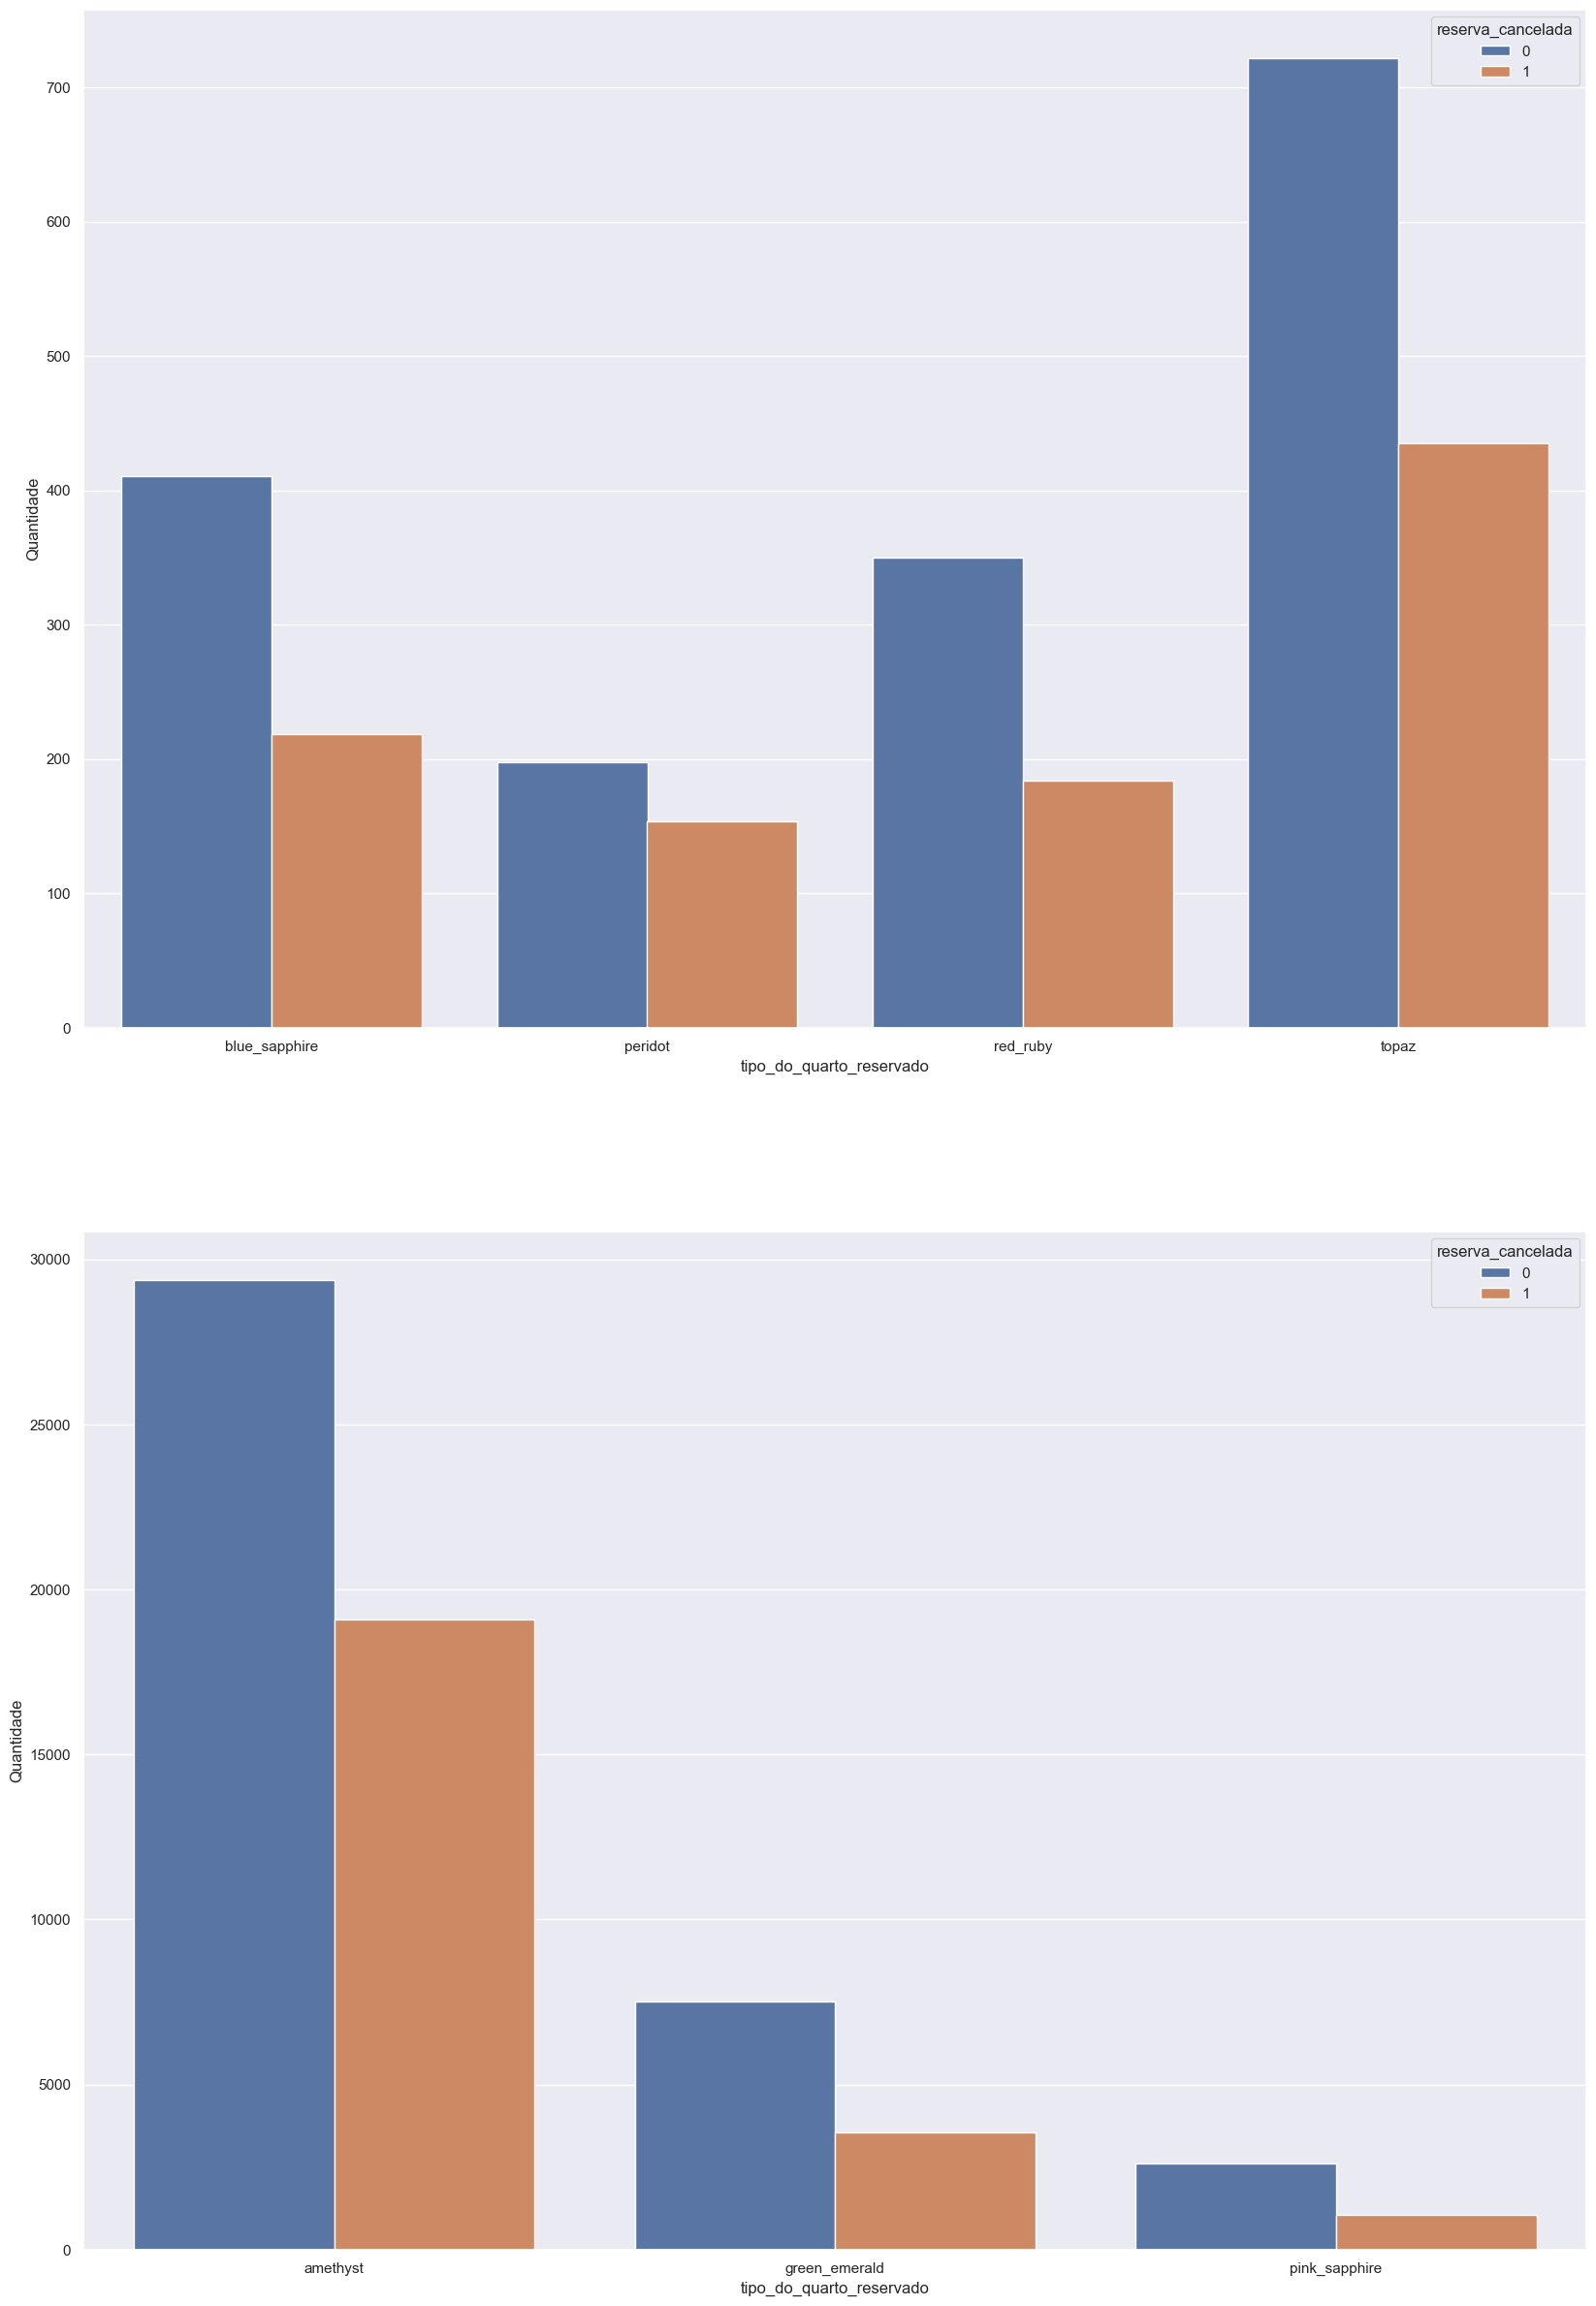

In [16]:
# Tipo do quarto reservado

quarto = df[['tipo_do_quarto_reservado', 'reserva_cancelada']].value_counts().reset_index().sort_values(by = 'tipo_do_quarto_reservado')
quarto = quarto.rename(columns={0: 'Quantidade'})

quarto_pequeno = quarto[quarto['tipo_do_quarto_reservado'].isin(['tanzante', 'topaz', 'blue_sapphire', 'red_ruby', 'peridot'])]
quarto_grande = quarto[quarto['tipo_do_quarto_reservado'].isin(['amethyst', 'green_emerald', 'pink_sapphire'])]

grid = gridspec.GridSpec(2, 2)
plt.figure(figsize=(20, 30))

# plot quarto pequeno
plt.subplot(grid[0, :])
sns.barplot(x = 'tipo_do_quarto_reservado', y = 'Quantidade', hue = 'reserva_cancelada', data = quarto_pequeno)

# plot quarto grande
plt.subplot(grid[1, :])
sns.barplot(x = 'tipo_do_quarto_reservado', y = 'Quantidade', hue = 'reserva_cancelada', data = quarto_grande)

## Correlações de Pearson

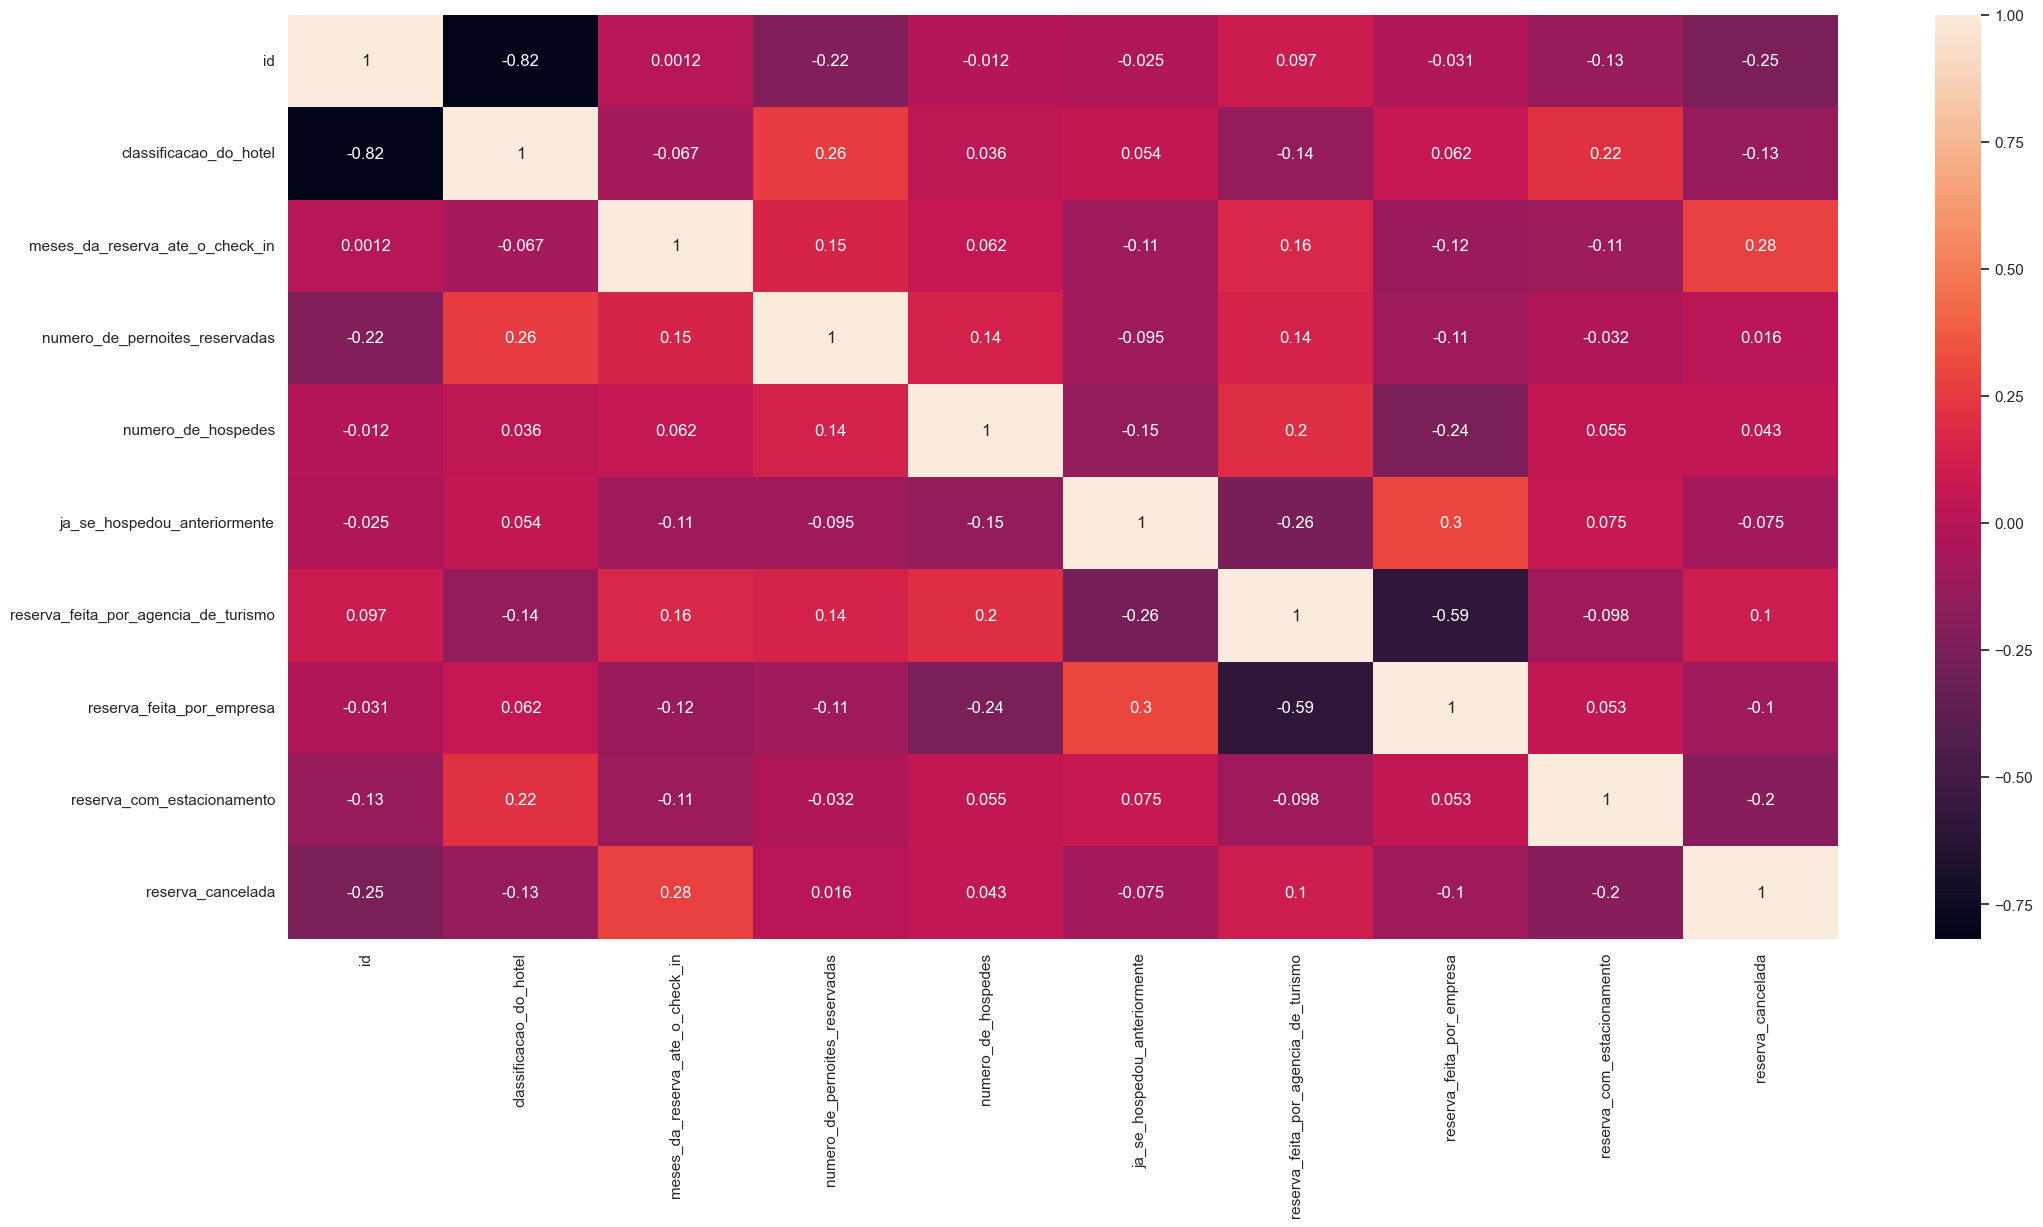

In [17]:
# Matriz de correlação entre duas variáveis numéricas através do método de Pearson
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

## Cramer's V

<AxesSubplot: >

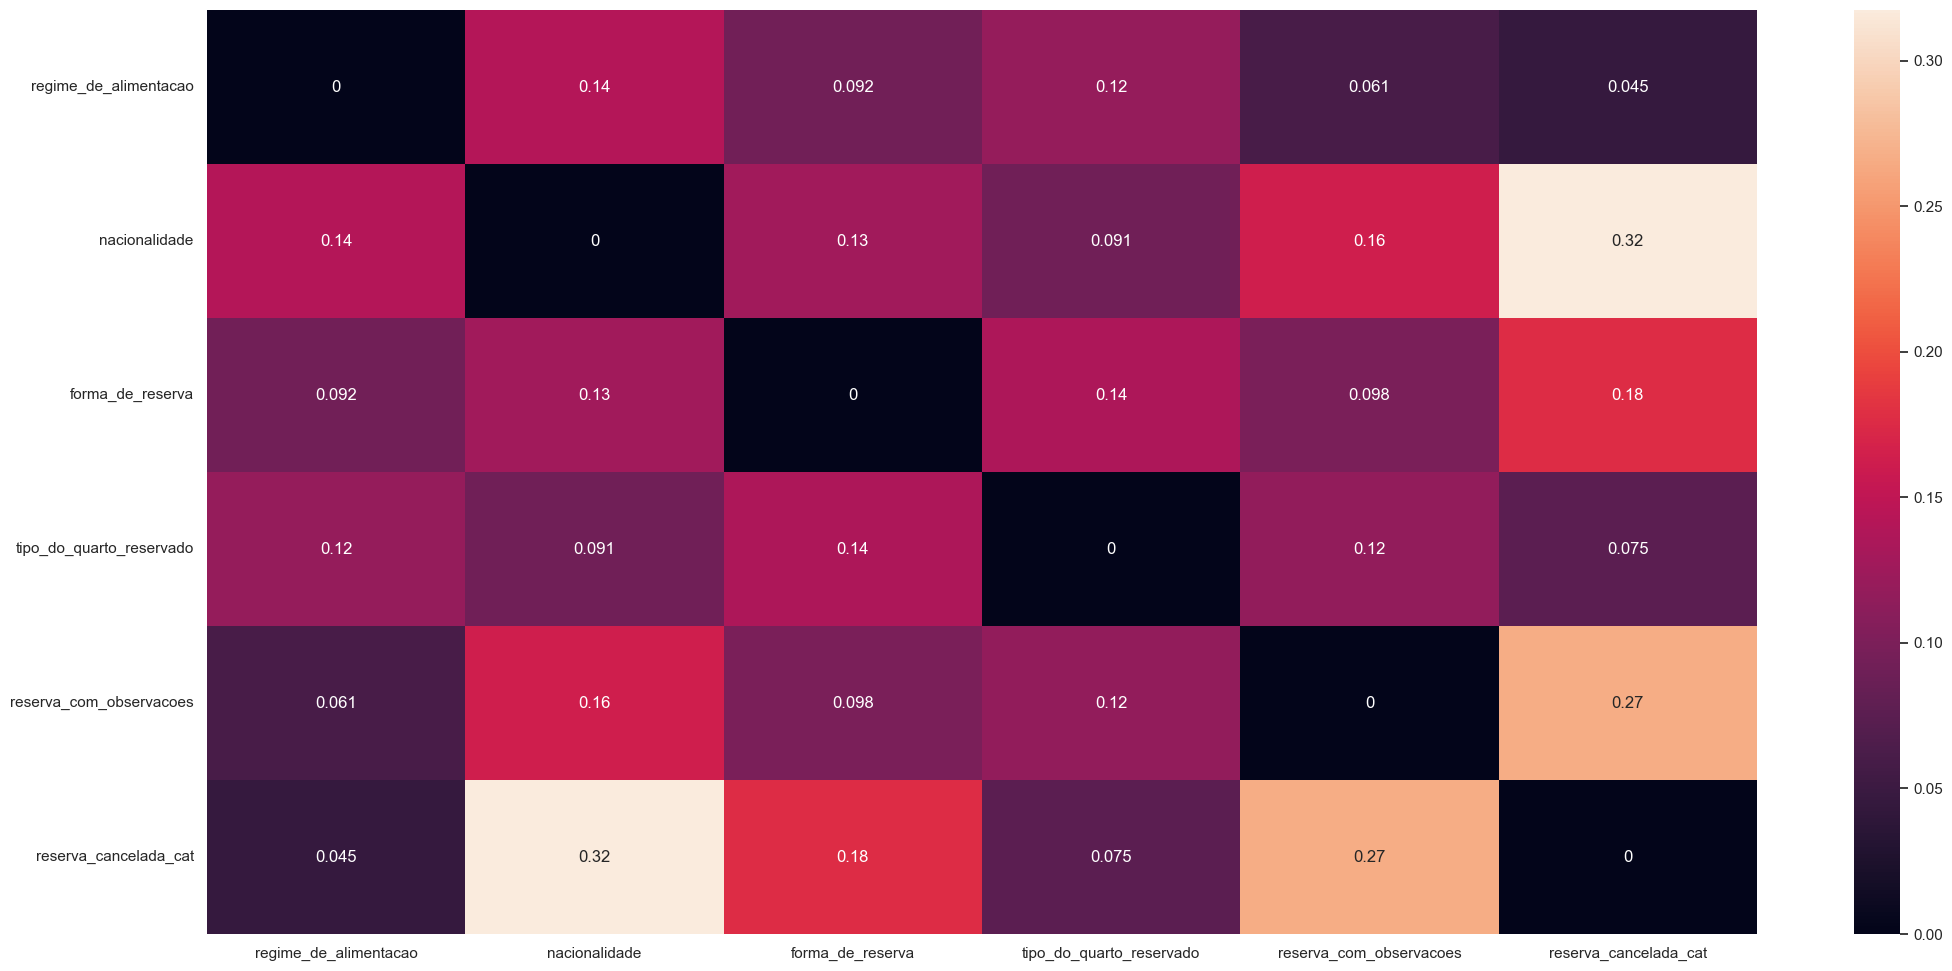

In [18]:
# Matriz de correlação entre duas variáveis categóricas através do método de Cramer
cols_cat = ['regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva', 'tipo_do_quarto_reservado', 'reserva_com_observacoes', 'reserva_cancelada_cat']
cols_cat_df = df.select_dtypes(include = 'object')

corrM = np.zeros((len(cols_cat),len(cols_cat)))

for col1, col2 in combinations(cols_cat, 2):
    idx1, idx2 = cols_cat.index(col1), cols_cat.index(col2)
    corrM[idx1, idx2] = cramer_v_confusion_matrix(pd.crosstab(cols_cat_df[col1], cols_cat_df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

d = pd.DataFrame(corrM, index=cols_cat, columns=cols_cat)
sns.heatmap(d, annot=True)

## Relatório da EDA com o SweetViz

In [19]:
df_sv = df.drop('reserva_cancelada_cat', axis = 1)

report = sv.analyze(source = df_sv, target_feat = 'reserva_cancelada')
report.show_html()

C:\Users\micro\anaconda3\envs\ds_em_producao\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
C:\Users\micro\anaconda3\envs\ds_em_producao\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: reserva_cancelada (TARGET)          |▋         | [  6%]   00:00 -> (00:01 left)C:\Users\micro\anaconda3\envs\ds_em_producao\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: id                                  |█▎        | [ 12%]   00:00 -> (00:01 left)C:\Users\mi

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Conclusão da análise exploratória

Tabela de hipóteses criada a partir da análise exploratória dos dados:

Revisando as hipóteses:

Hipóteses relacionadas as variáveis categóricas:
- 1. Hotéis com classificação 5 estrelas possuem uma proporção de cancelamentos menor que hotéis com classificação de 4 estrelas.
- 2. Clientes que já se hospedaram anteriormente possuem uma proporção de cancelamentos menor que clientes que nunca se hospedaram antes.
- 3. Reservas feitas por balcão tem uma proporção de cancelamento maior que as realizadas por agência de turismo ou B2B.
- 4. Reservas feitas com estacionamento possuem uma menor proporção de cancelamento.
- 5. Reservas feitas com café da manhã, almoço e jantar possuem uma menor proporção de cancelamento que as demais.
- 6. Reservas feitas sem nenhuma observação possuem uma maior proporção de cancelamento que as demais.
- 7. Reservas feitas por países do continente europeu possuem uma menor proporção de cancelamento as demais.

Hipóteses relacionadas as variáveis numéricas:
- 8. Reservas feitas com um tempo igual ou menor a 2 meses do período de check-in possuem uma menor proporção de cancelamento.
- 9. Reservas feitas com apenas uma pernoite possuem uma maior quantidade de cancelamentos, em média, que as demais.
- 10. Reservas feitas com 2 hóspedes possuem uma maior quantidade de cancelamentos, em média, que as demais.

Considerações:
- Conclusão: V para verdadeira, F para falsa, * para exceto Espanha.
- Relevância: B para baixa, M para média, A para alta.
- Insight: I para improvável, P para provável.

In [20]:
tab_hip = {
    'Hipótese': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Conclusão': ['V', 'V', 'F', 'V', 'V', 'V', 'V*', 'V', 'F', 'V'],
    'Relevância': ['B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'B'],
    'Insight': ['I', 'I', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P']
}

df_tab_hip = pd.DataFrame(tab_hip)
df_tab_hip

,Hipótese,Conclusão,Relevância,Insight
0,1,V,B,I
1,2,V,B,I
2,3,F,B,P
3,4,V,B,P
4,5,V,B,P
5,6,V,M,P
6,7,V*,M,P
7,8,V,M,P
8,9,F,B,P
9,10,V,B,P


Consideração sobre a coluna id:
- A coluna id está diretamente ligada ao comportamento das reservas canceladas.

É possível dividir os ids em 4 grupos:
- Do id 0 a 20 mil, em média, a quantidade de cancelamentos é muito maior que a quantidade de reservas confirmadas.
- Do id 20 mil ao 50 mil, em média, a quantidade de cancelamentos é muito menor que a quantidade de reservas confirmadas.
- Do id 50 mil ao id 80 mil, em média, a quantidade de cancelamentos é novamente muito maior que a quantidade de reservas confirmadas.
- Do id 80 mil em diante, em média, a quantidade de cancelamentos é novamente muito menor que a quantidade de reservas confirmadas.

Caso os códigos dos ids estejam diretamente ligados a data a qual foi feito o cadastro de cada cliente, é muito provável que o cancelamento das reservas seja explicado através das sazonalidades as quais foram realizadas as reservas, as quais possuem comportamentos diferentes. Estes comportamentos diferentes nas sazonalidades podem estar diretamente ligados à pandemia da Covid-19, onde houveram dois tipos de períodos distintos: períodos com aumentos nas restrições e períodos com diminuições nas restrições.

Sugestões à empresa:
- Como a proporção de cancelamentos por balcão é menor que as proporções por agência e B2B, oferecer pacotes com desconto, realizar parcerias com agências de turismo e com empresas e alocar recursos de marketing nestes grupos de clientes pode reduzir a taxa de cancelamentos.
- Inserir multas progressivas ou reembolsos parciais para cancelamentos de reservas realizadas a mais de 30 dias.
- Inserir pequenas multas progressivas ou reembolsos parciais para cancelamentos de reservas realizadas para 2 ou mais pernoites.

# Preparação dos dados

## Encodings

In [21]:
df1 = df.copy()

cols_drop = ['reserva_cancelada_cat']
df1 = df1.drop(cols_drop, axis = 1)

x_cat_cols = ['regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva', 'tipo_do_quarto_reservado', 'reserva_com_observacoes']

encoder = CountEncoder(cols = x_cat_cols, return_df = True)

df1 = encoder.fit_transform(df1)

Opção para o preenchimento de NaNs sem utilizar apenas a Espanha para aumentar um pouco a performance do modelo: preencher as linhas NaN da nacionalidade usando um outro algoritmo de classificação.

Para realizar a modificação, primeiro deve ser comentada a linha 23 e descomentada a linha 24 da Limpeza dos Dados, no snippet referente às premissas iniciais. O algoritmo de implementação pode ser visto nos snippets abaixo:

In [22]:
# df_nac = df.copy()

# nac_train = df_nac[df_nac['nacionalidade'] != 'nan']
# nacx_train = nac_train.drop(['nacionalidade','reserva_cancelada_cat'], axis = 1)
# nacy_train = nac_train.loc[:, 'nacionalidade']

# nac_test = df_nac[df_nac['nacionalidade'] == 'nan']
# nacx_test = nac_test.drop(['nacionalidade','reserva_cancelada_cat'], axis = 1)
# # nacy_test = nac_test.loc[:, 'nacionalidade']

# x_cat_cols_nac = ['regime_de_alimentacao', 'forma_de_reserva', 'tipo_do_quarto_reservado', 'reserva_com_observacoes']
# encoder_nacx = CountEncoder(cols = x_cat_cols_nac, return_df = True)
# y_cat_cols_nac = ['nacionalidade']
# encoder_nacy = CountEncoder(cols = y_cat_cols_nac, return_df = True)

# nacx_train = encoder_nacx.fit_transform(nacx_train)
# nacx_test = encoder_nacx.fit_transform(nacx_test)
# nacy_train = encoder_nacy.fit_transform(nacy_train)
# # nacy_test = encoder_nacy.fit_transform(nacy_test)

# nacy_train = nacy_train.values.ravel()
# # nacy_test = nacy_test.values.ravel()

# # k_list = np.arange(15, 22, 2)
   
# # for i in k_list:
# #     print(f'K Number: {i}')
# #     rf_classifier = RandomForestClassifier(n_estimators=100, max_depth = i, n_jobs=-1, random_state=42)
# #     scores = cross_val_score(rf_classifier, nacx_train, nacy_train, cv = 3, scoring = 'accuracy')
# #     print("Acurácia média:", scores.mean())

In [23]:
# # melhor max_depth = 19 - acurácia de 57,7%
# rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 19, n_jobs = -1, random_state = 42)
# rf_classifier.fit(nacx_train, nacy_train)
# nacy_pred = rf_classifier.predict(nacx_test)

# df_final_nac = nacx_test.loc[:, ['id']]
# df_final_nac['predicted'] = nacy_pred

In [24]:
# df1 = pd.merge(df1, df_final_nac, on = 'id', how = 'left')

# df1['nacionalidade'] = df1.apply(lambda x: x['predicted'] if math.isnan(x['nacionalidade']) else x['nacionalidade'], axis = 1)

# df1 = df1.drop(['predicted'], axis = 1)

# # df1.head(300)

## Seleção de features

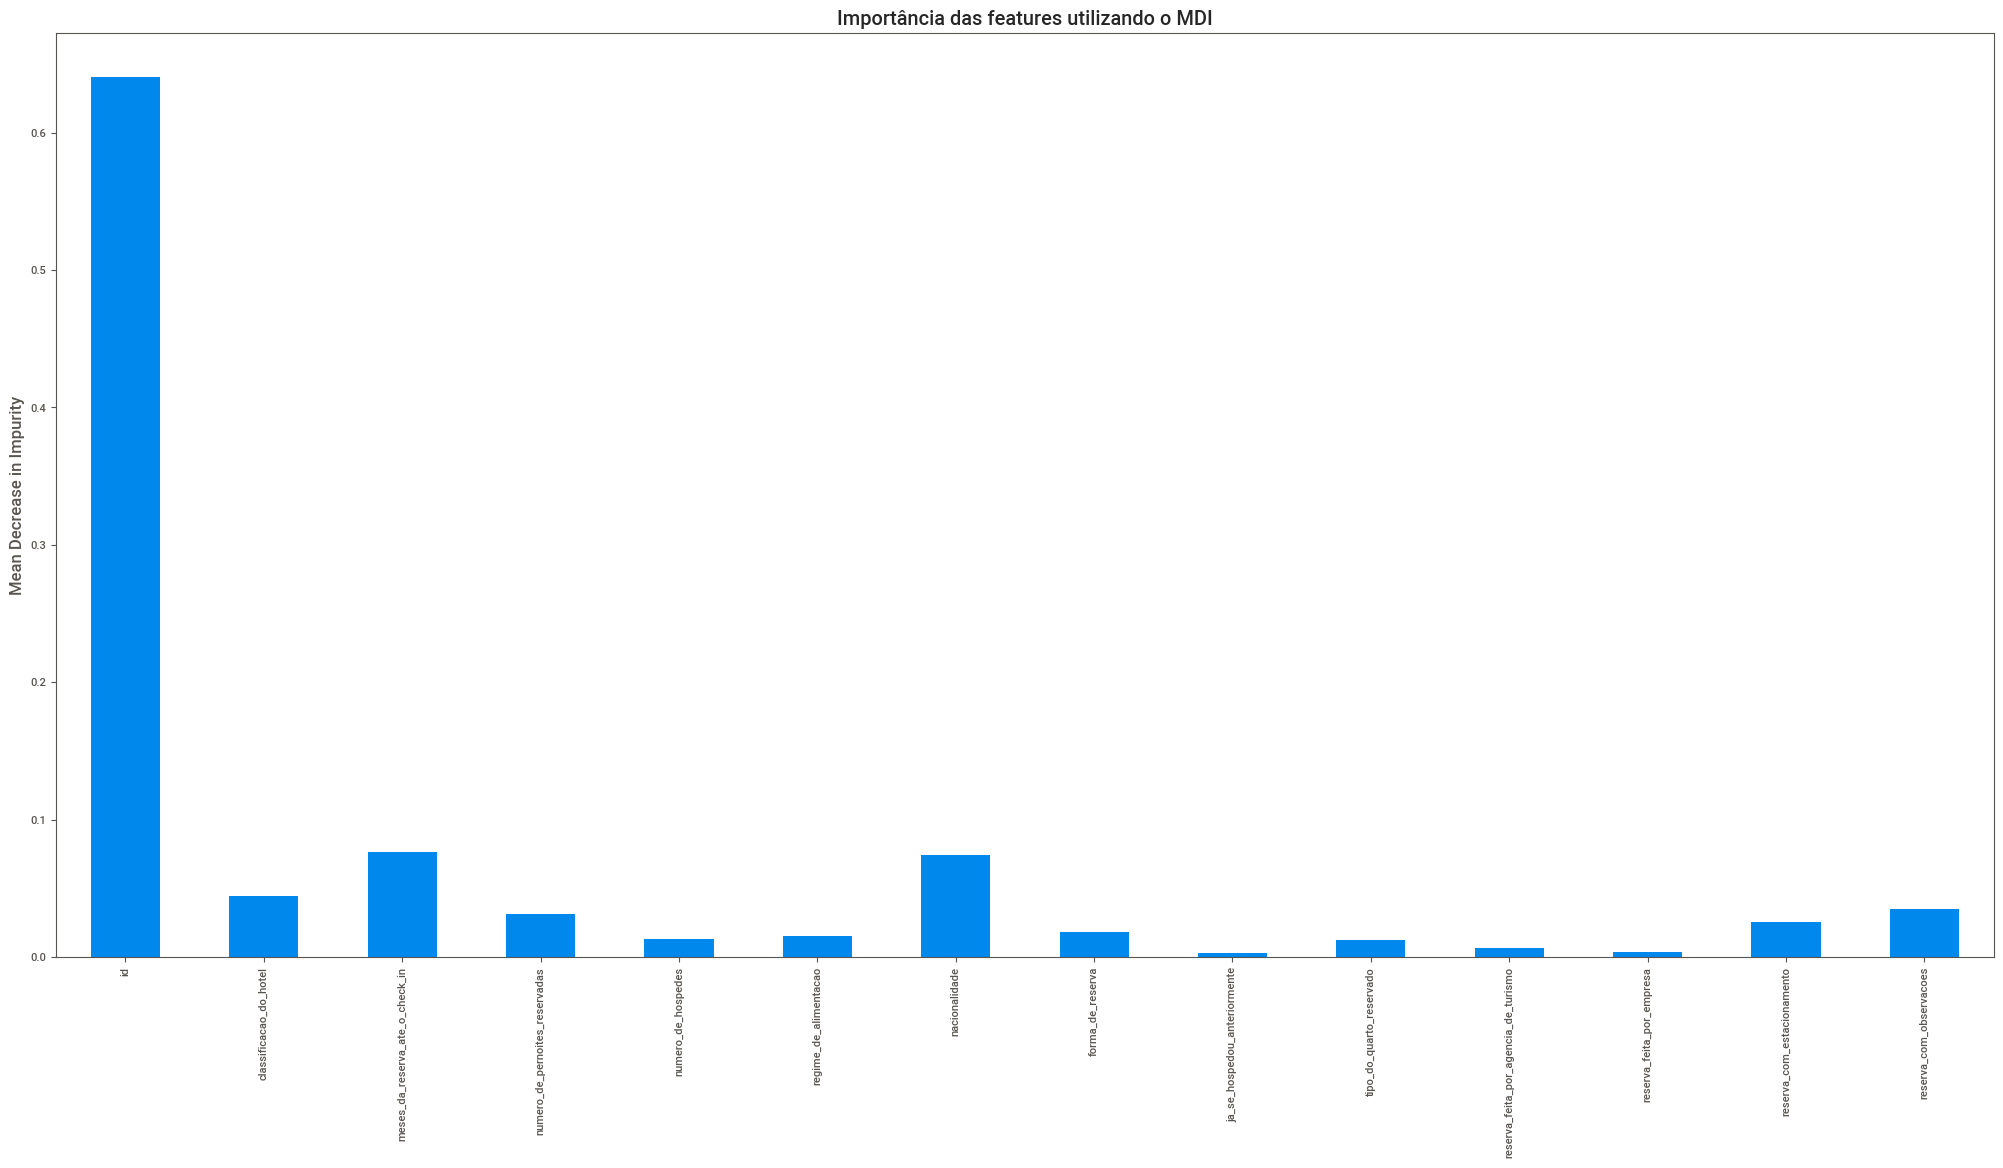

In [25]:
# Separação entre features e label
x_train_select = df1.drop(['reserva_cancelada'], axis = 1).values
y_train_select = df1['reserva_cancelada'].values.ravel()

# Treinando um modelo de random forest para selecionar as features
# Pode testar mais valores de estimadores para verificar, porém a diferença na importância das features é pequena.
model_select = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)
model_select.fit(x_train_select, y_train_select)

# Selecionando as features de maior importância através do modelo treinado
n_features = x_train_select.shape[1]
feature_names = [f"feature {i}" for i in range(n_features)]
importances = model_select.feature_importances_
forest_importances = pd.Series(importances, index = feature_names)

# MDI: calcula a redução média da impureza de cada feature
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title('Importância das features utilizando o MDI')
ax.set_ylabel('Mean Decrease in Impurity')
x_train_select_columns = df1.drop(['reserva_cancelada'], axis = 1).columns
ax.set_xticklabels(x_train_select_columns)
plt.xticks(rotation = 90);

In [26]:
row_labels = {'feature 0': 'id',
              'feature 1': 'classificacao_do_hotel',
              'feature 2': 'meses_da_reserva_ate_o_check_in',
              'feature 3': 'numero_de_pernoites_reservadas',
              'feature 4': 'numero_de_hospedes',
              'feature 5': 'regime_de_alimentacao',
              'feature 6': 'nacionalidade',
              'feature 7': 'forma_de_reserva',
              'feature 8': 'ja_se_hospedou_anteriormente',
              'feature 9': 'tipo_do_quarto_reservado',
              'feature 10': 'reserva_feita_por_agencia_de_turismo',
              'feature 11': 'reserva_feita_por_empresa',
              'feature 12': 'reserva_com_estacionamento',           
              'feature 13': 'reserva_com_observacoes'}

forest_importances.rename(index = row_labels, inplace = True)
df_forest_importances = pd.DataFrame(data = forest_importances).reset_index()
df_forest_importances.rename(columns = {'index': 'Features', 0: 'Relevância Percentual'}).sort_values(by = 'Relevância Percentual', ascending = False)

,Features,Relevância Percentual
0,id,0.640335
2,meses_da_reserva_ate_o_check_in,0.076407
6,nacionalidade,0.074165
1,classificacao_do_hotel,0.044707
13,reserva_com_observacoes,0.035258
3,numero_de_pernoites_reservadas,0.031313
12,reserva_com_estacionamento,0.025263
7,forma_de_reserva,0.018211
5,regime_de_alimentacao,0.015615
4,numero_de_hospedes,0.012893


In [27]:
# Dropando as colunas menos relevantes selecionadas (<1% de importância):
df1 = df1.drop(['reserva_feita_por_agencia_de_turismo', 'ja_se_hospedou_anteriormente', 'reserva_feita_por_empresa'], axis = 1)

# Modelagem dos dados

## Modelos iniciais

In [28]:
# Separando em features (x) e label (y)
x = df1.drop(['reserva_cancelada'], axis = 1)
y = df1['reserva_cancelada']

# Separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Treinando a Random Forest
rf_model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
f1_rf = cross_val_score(rf_model, x_train, y_train, cv = 5, scoring = 'f1_macro')
print("F1-Score Macro médio entre os 5 trechos do Cross-Validation para a Random Forest: ", f1_rf.mean())

# Treinando o XGBoost
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100, nthread = -1)
f1_xgb = cross_val_score(xgb_model, x_train, y_train, cv = 5, scoring = 'f1_macro')
print("F1-Score Macro médio entre os 5 trechos do Cross-Validation para o XGBoost: ", f1_xgb.mean())

# Treinando o LGBM
lgbm_model = lgbm.LGBMClassifier(boosting_type = 'gbdt', n_estimators = 100, random_state = 42, n_jobs = -1)
f1_lgbm = cross_val_score(lgbm_model, x_train, y_train, cv = 5, scoring = 'f1_macro')
print("F1-Score Macro médio entre os 5 trechos do Cross-Validation para o LGBM: ", f1_lgbm.mean())

F1-Score Macro médio entre os 5 trechos do Cross-Validation para a Random Forest:  0.9698837271885921
F1-Score Macro médio entre os 5 trechos do Cross-Validation para o XGBoost:  0.9689395163525788
F1-Score Macro médio entre os 5 trechos do Cross-Validation para o LGBM:  0.9636845762360678


Não vale a pena aplicar a random forest nos NaNs da nacionalidade, pois a melhora no f1-score macro médio é de apenas 0,05% para o XGBoost e de 0,02% para a Random Forest.

Fica como sugestão para um próximo ciclo de projeto realizar a separação entre treino e teste tratando o id como parâmetro referencial devido a sua potencial indicação de sazonalidade. Ou seja, os ids maiores devem ser separados para teste, enquanto os demais ficam como treino. Desta forma, os resultados do algoritmo seriam mais fiéis, pois o problema seria tratado como uma time-series.

## Tunagem dos parâmetros

In [29]:
# # Por apresentar um F1-Score Macro médio um pouco maior, foi escolhido seguir com a tunagem do XGBoost

# # Lista de parâmetros para teste de tunagem
# param_tun = {
#     'n_estimators': [500, 600, 700, 800, 900],
#     'learning_rate': [0.002, 0.005, 0.01, 0.02, 0.05],
#     'eta': [0.002, 0.005, 0.01, 0.02, 0.05],
#     'max_depth': [13, 15, 18, 20, 25],
#     'subsample': [0.6, 0.7, 0.75, 0.8, 0.9],
#     'colsample_bytree': [0.6, 0.7, 0.75, 0.8, 0.9]
# }

# # Modelo XGBoost a ser turnado
# xgb_tun = xgb.XGBClassifier(objective = 'binary:logistic', nthread = -1)

# # Métrica a ser avaliada
# f1_tun = make_scorer(f1_score, average = 'macro')

# # Tunagem utilizando Grid Search
# grid_search_model = GridSearchCV(estimator = xgb_tun,
#                            param_grid = param_tun, 
#                            scoring = f1_tun,
#                            n_jobs = -1,
#                            cv = 5,
#                            verbose = 3)
 
# # Treino do modelo tunado com Grid Search
# grid_search_model.fit(x_train, y_train)

# # Tunagem utilizando Bayes Search
# bayes_search_model = BayesSearchCV(estimator = xgb_tun,
#                            search_spaces = param_tun, 
#                            scoring = f1_tun,
#                            n_iter = 100,
#                            n_jobs = -1,
#                            verbose = 2,
#                            cv = 5,
#                            random_state = 42)

# # Treino do modelo tunado com Bayes Search
# bayes_search_model.fit(x_train, y_train)

# # Tunagem utilizando Random Search
# random_search_model = RandomizedSearchCV(estimator = xgb_tun,
#                            param_distributions = param_tun, 
#                            n_iter = 10,
#                            scoring = f1_tun,
#                            n_jobs = -1,
#                            cv = 5,
#                            verbose = 2,
#                            random_state = 42)
 
# # Treino do modelo tunado com Random Search
# random_search_model.fit(x_train, y_train)

In [30]:
# bayes_search_model.best_params_

Os métodos de tunagem foram separados em: Grid Search, Random Search e Bayes Search.
- Grid Search: foi descartada devido ao tempo de resposta ser muito alto. Como a performance do modelo já é considerada bem elevada mesmo sem a tunagem, do ponto de vista de negócio, para uma entrega de solução rápida, a Grid Search acaba sendo inviável.
- Random Search: apresentou uma relativa demora na execução, mesmo para uma quantidade de apenas 10 iterações. Além disso, apresentou um resultado inferior à Bayes Search.
- Bayes Search: foi a escolhida por ter alcançado a melhor performance e por ter demorado menos tempo para ser executada (4h30min).

## Generalização do modelo

In [31]:
# Modelo com os melhores parâmetros obtidos na tunagem
xgb_final = xgb.XGBClassifier(objective = 'binary:logistic',
                        n_estimators = 700,
                        eta = 0.01,
                        max_depth = 20,
                        learning_rate = 0.02,
                        subsample = 0.7,                       
                        colsample_bytree = 0.8,
                        nthread = -1)

# Retreino do modelo
xgb_final.fit(x_train, y_train)

# predição sobre os dados de teste
yhat_test = xgb_final.predict(x_test)

# performance após a tunagem e generalização do modelo
f1_test = mt.f1_score(y_test, yhat_test)
precision_test = mt.precision_score(y_test, yhat_test)
recall_test = mt.recall_score(y_test, yhat_test)
print("F1-Score Macro médio final: ", f1_test)
print("Precision média final: ", precision_test)
print("Recall médio final: ", recall_test)

F1-Score Macro médio final:  0.9634315082032021
Precision média final:  0.9676394679372643
Recall médio final:  0.9592599881913009


In [32]:
# treinando novamente o modelo juntando os dados de treino e teste para mandar para a produção
xgb_final = xgb.XGBClassifier(objective = 'binary:logistic',
                        n_estimators = 700,
                        eta = 0.01,
                        max_depth = 20,
                        learning_rate = 0.02,
                        subsample = 0.7,                       
                        colsample_bytree = 0.8,
                        nthread = -1)

xgb_final.fit(np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test)))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              nthread=-1, num_parallel_tree=None, ...)

# Resultados financeiros

Para traduzir os resultados do modelo em resultados financeiros, é possível realizar a seguinte análise:

- Percentual de reservas canceladas: 37,3%.
- F1-Score Macro médio do algoritmo (pós generalização): 96,3%.
- Percentual de reservas canceladas que o algoritmo consegue prever (recall): 95,9%.

Multiplicando o percentual de reservas canceladas pelo recall do algoritmo:
37,3% * 95,9% = 35,8%.

Deste modo, o aumento que a empresa terá com reservas em sua receita pode chegar até 35,8%. Isso ocorreria caso ela conseguisse reverter 100% dos cancelamentos. Portanto, para prever o percentual de aumento de receita através das reservas a empresa deve multiplicar os 35,8% pela sua taxa de reversão de cancelamentos.

Exemplo prático:

A diária tem um ticket médio de USS 1.000,00 e consegue uma quantidade média de 1.000 reservas diárias. Em um dia, a empresa está perdendo, em média, 373 reservas, totalizando o valor médio diário de USS 373.000,00, mensal de USS 11.190.000,00 e anual de USS 134.280.000,00.

Considere uma taxa de reversão de cancelamentos hipotética da empresa de 50%. Multiplicando este valor pelo percentual de reservas canceladas que o algoritmo consegue prever, que é de 35,8%, é obtido um valor percentual médio de reservas canceladas de 17,9%. Então, em um dia, a empresa consegue reverter 179 cancelamentos (17,9% de 1000 reservas diárias), totalizando o valor médio diário de USS 179.000,00, mensal de USS 5.370.000,00 e anual de USS 64.440.000,00!

Em comparação, com o baseline de 67% setado no início do projeto o retorno seria de:
- 37,3% * 67% * 50% = 12,5%

Ou seja, a empresa conseguiria recuperar 125 clientes, totalizando um valor médio diário de USS 125.000,00, mensal de USS 3.750.000,00 e anual de USS 45.000.000,00.

Fazendo a diferença entre o potencial do algoritmo do projeto em relação ao algoritmo baseline, o valor médio anual obtido é USS 19.440.000,00 maior!

# Modelo em produção

In [33]:
# Salvando o arquivo do modelo treinado

import pickle
pickle.dump(xgb_final, open('C:\\Users\\micro\\Desktop\\repos\\3_ciclo_intermediario\\4_hackday\\xgb_production_vf.pkl', 'wb'))

In [34]:
# Design do ETL para aplicar as mesmas modificações do treino no teste

import pickle
import math

import pandas as pd
import numpy as np

from category_encoders.count import CountEncoder

# lê o modelo
xgb_final = pickle.load(open('C:\\Users\\micro\\Desktop\\repos\\3_ciclo_intermediario\\4_hackday\\xgb_production_vf.pkl', 'rb'))

def get_data(path):
    
    test = pd.read_csv(path)
    df = test.copy()

    return df

def data_cleaning(df):
   
    # renomeando colunas
    cols_new = ['id',
     'classificacao_do_hotel',
     'meses_da_reserva_ate_o_check_in',
     'numero_de_pernoites_reservadas',
     'numero_de_hospedes',
     'regime_de_alimentacao',
     'nacionalidade',
     'forma_de_reserva',
     'ja_se_hospedou_anteriormente',
     'tipo_do_quarto_reservado',
     'reserva_feita_por_agencia_de_turismo',
     'reserva_feita_por_empresa',
     'reserva_com_estacionamento',
     'reserva_com_observacoes']
    df.columns = cols_new

    # limpando coluna classificação do hotel
    df['classificacao_do_hotel'] = df.apply(lambda line: line['classificacao_do_hotel'].replace(' estrelas', ' '), axis = 1)

    # preenchendo NAS da coluna número de hospedes com o valor mínimo de hospedes
    df['numero_de_hospedes'] = df['numero_de_hospedes'].apply(lambda x: 1 if math.isnan(x) else x)

    # transformando tipos das colunas
    df['classificacao_do_hotel'] = df['classificacao_do_hotel'].astype('int64')
    df['numero_de_hospedes'] = df['numero_de_hospedes'].astype('int64')
    df['numero_de_pernoites_reservadas'] = df['numero_de_pernoites_reservadas'].astype('int64')
    df['meses_da_reserva_ate_o_check_in'] = df['meses_da_reserva_ate_o_check_in'].astype('int64')

    # transformando as colunas categóricas de não em sim em numéricas de 0 e 1 para facilitar as análises
    df['ja_se_hospedou_anteriormente'] = df['ja_se_hospedou_anteriormente'].apply(lambda x: 0 if x == 'Não' else 1)
    df['reserva_com_estacionamento'] = df['reserva_com_estacionamento'].apply(lambda x: 0 if x == 'Não' else 1)
    df['reserva_feita_por_agencia_de_turismo'] = df['reserva_feita_por_agencia_de_turismo'].apply(lambda x: 0 if x == 'Não' else 1)
    df['reserva_feita_por_empresa'] = df['reserva_feita_por_empresa'].apply(lambda x: 0 if x == 'Não' else 1)

    # preenchendo os NAs da nacionalidade com Espanha, por ser o país da rede hoteleira
    df = df.fillna('Spain')

    # nacionalidade
    snakecase = lambda x: inflection.underscore(x)
    rows_nac = list(map(snakecase, df['nacionalidade']))
    df['nacionalidade'] = rows_nac
    df['nacionalidade'] = [i.replace(' ', '_') for i in df['nacionalidade']]
    df['nacionalidade'] = [i.replace(',', '_') for i in df['nacionalidade']]
    df['nacionalidade'] = [i.replace("'", '_') for i in df['nacionalidade']]
    df['nacionalidade'] = [i.replace("ô", 'o') for i in df['nacionalidade']]
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'russia' if (x == 'russia') | (x == 'russian_federation') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'south_korea' if (x == 'south_korea') | (x == 'korea__republic_of') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'ivory_coast' if (x == 'ivory_coast') | (x == 'cote_d_ivoire') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'iran' if (x == 'iran') | (x == 'iran__islamic_republic_of') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'tanzania' if (x == 'tanzania') | (x == 'tanzania__united_republic_of') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'taiwan' if (x == 'taiwan') | (x == 'taiwan__province_of_china') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'france' if (x == 'france') | (x == 'monaco') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'venezuela' if (x == 'venezuela') | (x == 'venezuela__bolivarian_republic_of') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'bolivia' if (x == 'bolivia') | (x == 'bolivia__plurinational_state_of') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'macedonia' if (x == 'macedonia') | (x == 'macedonia__the_former_yugoslav_republic_of') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'dominican_republic' if (x == 'dominica') | (x == 'dominican_republic') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'libya' if (x == 'libya') | (x == 'libyan_arab_jamahiriya') else x)
    df['nacionalidade'] = df['nacionalidade'].apply(lambda x: 'vietnam' if (x == 'vietnam') | (x == 'viet_nam') else x)

    df_clean = df

    return df_clean

def data_preparation(df_clean):
    
    # encodings e seleção de features
    x_cat_cols = ['regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva', 'tipo_do_quarto_reservado', 'reserva_com_observacoes']
    encoder = CountEncoder(cols=x_cat_cols, return_df=True)
    df_clean = encoder.fit_transform(df_clean)

    df_clean = df_clean.drop(['reserva_feita_por_agencia_de_turismo', 'ja_se_hospedou_anteriormente', 'reserva_feita_por_empresa'], axis=1)
    
    df_prep = df_clean

    return df_prep

def get_prediction(df_prep, path):
    
    test = pd.read_csv(path)
    
    # predição dos dados de teste
    predicao = xgb_final.predict(df_prep)
    
    df_final = pd.concat([test.id, pd.Series(predicao, name='reserva_cancelada')], axis=1)

    return df_final.to_csv('submission.csv', index=False)

if __name__ == "__main__":

    path = 'test.csv'
    df = get_data(path)

    df_clean = data_cleaning(df)
    df_prep = data_preparation(df_clean)

    df_final = get_prediction(df_prep, path)